<a href="https://colab.research.google.com/github/yuvalzarbiv/MachineLearning--FootballFinalPtoject/blob/main/FootballFinalPtoject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

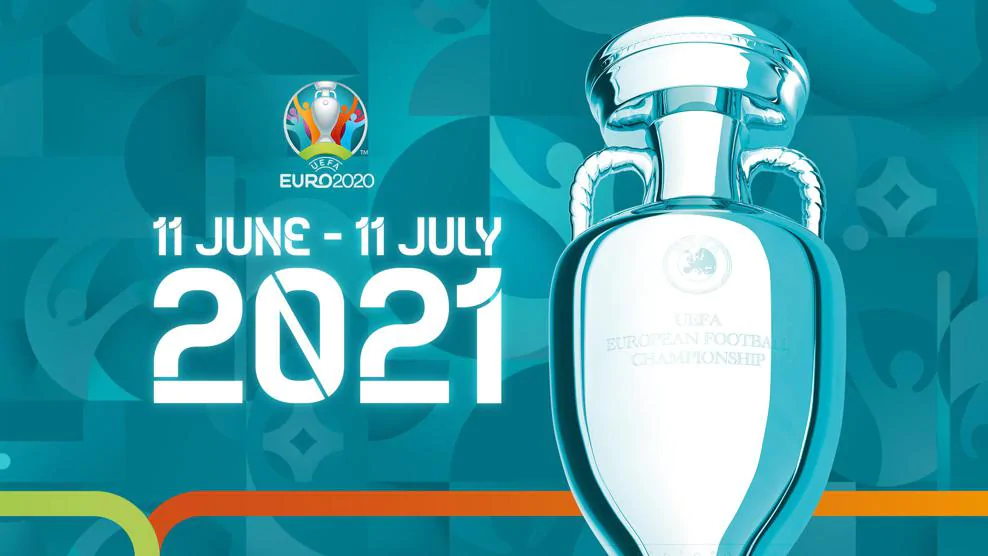

In [ ]:
# add google drive to colab 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Question 1 -
## Predict the euro champions using logistic regression probabillity and polynomial features
1. The rank diff
2. Rank avg
3. Goal avg diff historically


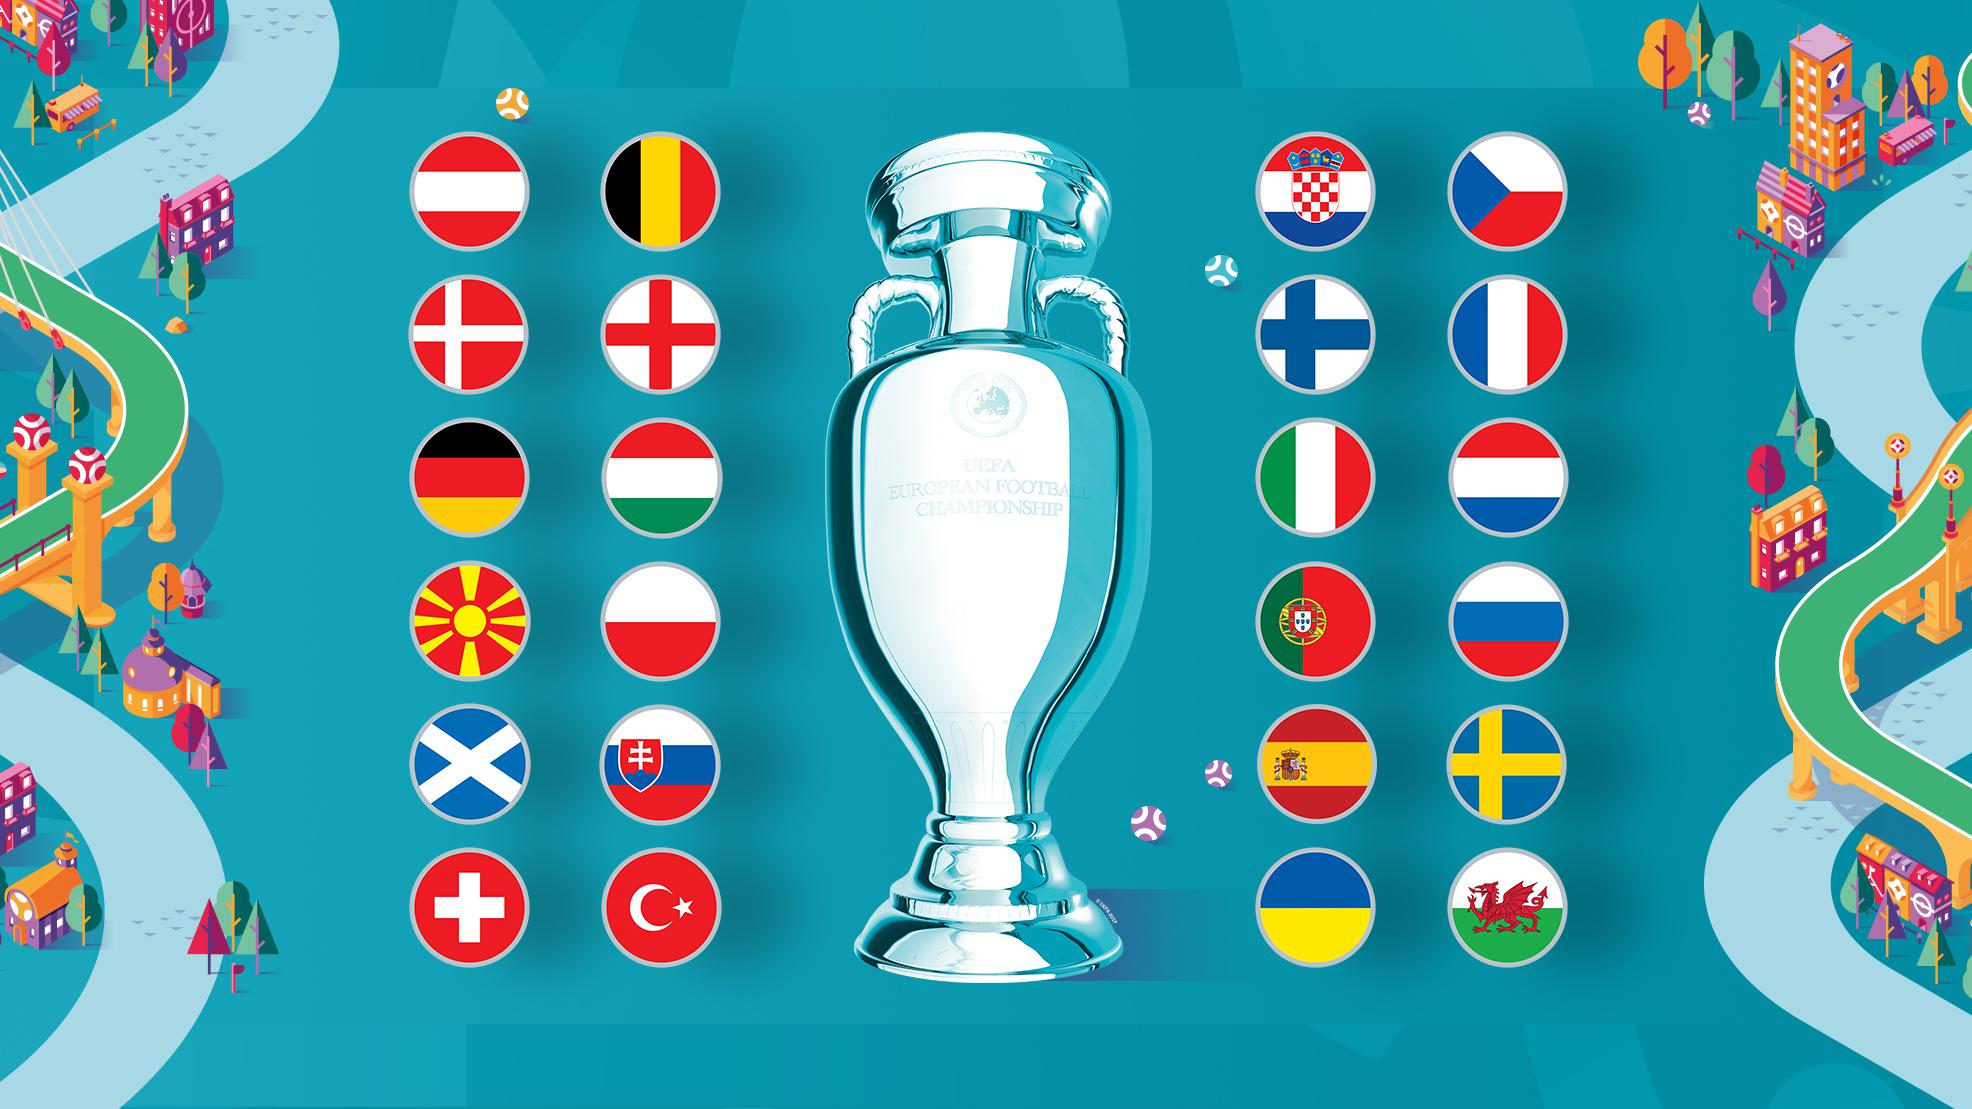

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [ ]:
import pandas as pd
matches = pd.read_csv("/content/drive/MyDrive/Football_Data/All matches results/results.csv")
matches['date'] = pd.to_datetime(matches['date'])
matches

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False
...,...,...,...,...,...,...,...,...,...
42400,2021-07-06,Trinidad and Tobago,French Guiana,8.0,1.0,Gold Cup qualification,Fort Lauderdale,United States,True
42401,2021-07-07,England,Denmark,NaN,NaN,UEFA Euro,London,England,False
42402,2021-07-09,NaN,NaN,NaN,NaN,Copa América,Brasília,Brazil,NaN
42403,2021-07-10,NaN,NaN,NaN,NaN,Copa América,Rio de Janeiro,Brazil,NaN


In [ ]:
euro_2020 = pd.read_csv("/content/drive/MyDrive/Football_Data/Rankings/Eufa 2020 euro fictures.csv")
euro_2020 = euro_2020.set_index("Team")

euro_2020

,Group,First match \nagainst,Second match\n against,Third match\n against
Team,,,,
Italy,A,Turkey,Switzerland,Wales
Switzerland,A,Wales,Italy,Turkey
Turkey,A,Italy,Switzerland,Wales
Wales,A,Switzerland,Japan,Italy
Belgium,B,Russia,Denmark,Finland
Denmark,B,Finland,Belgium,Russia
Finland,B,Denmark,Russia,Belgium
Russia,B,Belgium,Finland,Denmark
Netherlands,C,Ukraine,Austria,North Macedonia


In [ ]:
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

##making the features:
1. point and rank differences
2. score diffrence through the years
3. the game was friendly of not

In [ ]:
#save the average rank for every team in all the rank dates
rankings = pd.read_csv("/content/drive/MyDrive/Football_Data/Rankings/fifa_ranking-2021-05-27.csv")
rankings = rankings.loc[:,['rank','country_full','rank_date']]
rankings['rank_date'] = pd.to_datetime(rankings['rank_date'])

rankings = rankings.set_index(['rank_date']).groupby(['country_full'], group_keys=False).resample('D').first().fillna(method='ffill').reset_index()

In [ ]:
#web scraping from wikipedia all the uefa (european) national teams for filtering only the european teams
response = requests.get(
	url="https://en.wikipedia.org/wiki/UEFA",
)
soup = BeautifulSoup(response.content, 'lxml')
teams = soup.select("tbody")
all_European_teams = teams[32].text.split("\n")
all_European_teams.remove("vteNational football teams of Europe (UEFA)Active")
all_European_teams.remove("Yugoslavia (Serbia and Montenegro)")
all_European_teams.remove("Ireland (1882–1950)")
all_European_teams.remove("Soviet Union (CIS)")
all_European_teams.remove("East Germany")
all_European_teams.remove("Defunct")
all_European_teams.remove("Saarland")
all_European_teams.remove("")

all_European_teams.append("Yugoslavia")
#the final list of all teams
print(all_European_teams)


['Albania', 'Andorra', 'Armenia', 'Austria', 'Azerbaijan', 'Belarus', 'Belgium', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'England', 'Estonia', 'Faroe Islands', 'Finland', 'France', 'Georgia', 'Germany', 'Gibraltar', 'Greece', 'Hungary', 'Iceland', 'Israel', 'Italy', 'Kazakhstan', 'Kosovo', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Moldova', 'Montenegro', 'Netherlands', 'North Macedonia', 'Northern Ireland', 'Norway', 'Poland', 'Portugal', 'Republic of Ireland', 'Romania', 'Russia', 'San Marino', 'Scotland', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'Ukraine', 'Wales', 'Czechoslovakia', 'Yugoslavia']


In [ ]:
#add to matches dataframe the inforamtion about each team, their avg rank at the date the game was played from rankings dataframe
matches = matches.merge(rankings, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])
matches = matches.merge(rankings, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))

In [ ]:
#creating new columns that sum all the diffrence between the teams.
matches['rank_difference'] = matches['rank_home'] - matches['rank_away'] # add column of rank diff.
matches['average_rank'] = (matches['rank_home'] + matches['rank_away'])/2 # add column of rank avg.
matches['score_difference'] = matches['home_score'] - matches['away_score'] # add column of score diff of the match.
matches['is_stake'] = matches['tournament'] != 'Friendly' #every game that is not friendly means more, the stroger players will play.
matches['is_won'] = matches['score_difference'] > 0 # take draw as lost.

matches

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_date_home,rank_home,country_full_home,rank_date_away,rank_away,country_full_away,rank_difference,average_rank,score_difference,is_stake,is_won
0,1993-01-01,Ghana,Mali,1.0,1.0,Friendly,Libreville,Gabon,True,1993-01-01,39.0,Ghana,1993-01-01,69.0,Mali,-30.0,54.0,0.0,False,False
1,1993-01-02,Gabon,Burkina Faso,1.0,1.0,Friendly,Libreville,Gabon,False,1993-01-02,55.0,Gabon,1993-01-02,97.0,Burkina Faso,-42.0,76.0,0.0,False,False
2,1993-01-02,Kuwait,Lebanon,2.0,0.0,Friendly,Kuwait City,Kuwait,False,1993-01-02,71.0,Kuwait,1993-01-02,161.0,Lebanon,-90.0,116.0,2.0,False,True
3,1993-01-03,Burkina Faso,Mali,1.0,0.0,Friendly,Libreville,Gabon,True,1993-01-03,97.0,Burkina Faso,1993-01-03,69.0,Mali,28.0,83.0,1.0,False,True
4,1993-01-03,Gabon,Ghana,2.0,3.0,Friendly,Libreville,Gabon,False,1993-01-03,55.0,Gabon,1993-01-03,39.0,Ghana,16.0,47.0,-1.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19960,2021-05-24,Iraq,Tajikistan,0.0,0.0,Friendly,Basra,Iraq,False,2021-05-24,68.0,Iraq,2021-05-24,121.0,Tajikistan,-53.0,94.5,0.0,False,False
19961,2021-05-24,United Arab Emirates,Jordan,5.0,1.0,Friendly,Dubai,United Arab Emirates,False,2021-05-24,73.0,United Arab Emirates,2021-05-24,95.0,Jordan,-22.0,84.0,4.0,False,True
19962,2021-05-25,Indonesia,Afghanistan,2.0,3.0,Friendly,Dubai,United Arab Emirates,True,2021-05-25,173.0,Indonesia,2021-05-25,149.0,Afghanistan,24.0,161.0,-1.0,False,False
19963,2021-05-25,Oman,Thailand,1.0,0.0,Friendly,Dubai,United Arab Emirates,True,2021-05-25,80.0,Oman,2021-05-25,106.0,Thailand,-26.0,93.0,1.0,False,True


In [ ]:
# all Euro matches 1960 - 2016 database
#Euro_teams_matches = pd.read_csv("/content/drive/MyDrive/Football_Data/Euro 1960 -2016/All Matches.csv")
#all matches results from 1890 - 2020 database
#Euro_teams_matches
#print(All_matches_result.head())

In [ ]:
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

In [ ]:
# creating new dataframe with scoring avg of all teams from all matches in history
All_matches_result = pd.read_csv("/content/drive/MyDrive/Football_Data/All matches results/results.csv")
All_scores_new = pd.DataFrame(index = [str(x) for x in all_European_teams],columns = ["Goals_avg"])
for i in range(len(All_scores_new)):
  All_scores_new["Goals_avg"][all_European_teams[i]] =  (All_matches_result.loc[All_matches_result['away_team'] == all_European_teams[i], 'away_score'].sum() + All_matches_result.loc[All_matches_result['home_team'] == all_European_teams[i], 'home_score'].sum() )/ ( All_matches_result.loc[All_matches_result['away_team'] == all_European_teams[i], 'away_team' ].count() + All_matches_result.loc[All_matches_result['home_team'] == all_European_teams[i],'home_team'].count() )


#add to matches dataframe the goal diff between every team and her opponent, if the tames not in europe add 0 to theire column
matches["goal_diff_home"] = ""
for i in range(len(matches)):
  if (matches['country_full_home'][i] in All_scores_new.index.values.tolist() and matches['country_full_away'][i] in All_scores_new.index.values.tolist()):
    matches["goal_diff_home"][i] = All_scores_new["Goals_avg"][matches['country_full_home'][i]] - All_scores_new["Goals_avg"][matches['country_full_away'][i]]
  else: 
    matches["goal_diff_home"][i] = 0
matches


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_date_home,rank_home,country_full_home,rank_date_away,rank_away,country_full_away,rank_difference,average_rank,score_difference,is_stake,is_won,goal_diff_home
0,1993-01-01,Ghana,Mali,1.0,1.0,Friendly,Libreville,Gabon,True,1993-01-01,39.0,Ghana,1993-01-01,69.0,Mali,-30.0,54.0,0.0,False,False,0
1,1993-01-02,Gabon,Burkina Faso,1.0,1.0,Friendly,Libreville,Gabon,False,1993-01-02,55.0,Gabon,1993-01-02,97.0,Burkina Faso,-42.0,76.0,0.0,False,False,0
2,1993-01-02,Kuwait,Lebanon,2.0,0.0,Friendly,Kuwait City,Kuwait,False,1993-01-02,71.0,Kuwait,1993-01-02,161.0,Lebanon,-90.0,116.0,2.0,False,True,0
3,1993-01-03,Burkina Faso,Mali,1.0,0.0,Friendly,Libreville,Gabon,True,1993-01-03,97.0,Burkina Faso,1993-01-03,69.0,Mali,28.0,83.0,1.0,False,True,0
4,1993-01-03,Gabon,Ghana,2.0,3.0,Friendly,Libreville,Gabon,False,1993-01-03,55.0,Gabon,1993-01-03,39.0,Ghana,16.0,47.0,-1.0,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19960,2021-05-24,Iraq,Tajikistan,0.0,0.0,Friendly,Basra,Iraq,False,2021-05-24,68.0,Iraq,2021-05-24,121.0,Tajikistan,-53.0,94.5,0.0,False,False,0
19961,2021-05-24,United Arab Emirates,Jordan,5.0,1.0,Friendly,Dubai,United Arab Emirates,False,2021-05-24,73.0,United Arab Emirates,2021-05-24,95.0,Jordan,-22.0,84.0,4.0,False,True,0
19962,2021-05-25,Indonesia,Afghanistan,2.0,3.0,Friendly,Dubai,United Arab Emirates,True,2021-05-25,173.0,Indonesia,2021-05-25,149.0,Afghanistan,24.0,161.0,-1.0,False,False,0
19963,2021-05-25,Oman,Thailand,1.0,0.0,Friendly,Dubai,United Arab Emirates,True,2021-05-25,80.0,Oman,2021-05-25,106.0,Thailand,-26.0,93.0,1.0,False,True,0


In [ ]:
#enter to X => ['average_rank', 'rank_difference','goal_diff_home','is_stake']
#enter to Y => ['is won']
X, y = matches.loc[:,['average_rank', 'rank_difference','goal_diff_home','is_stake']], matches['is_won']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42) # split the data

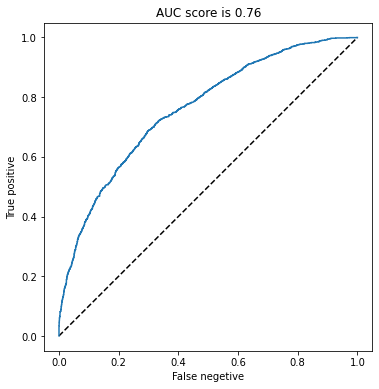

In [ ]:
#creating logistic regression model
logreg = linear_model.LogisticRegression()

#create the polynomial features to get better accuracy
features = PolynomialFeatures(degree=2)


# using the pipeline makes the x_train shape bigger to get the polynomial accuricy when doing the fit on the data (better fit to the values)
# it takes the original 3, their square, and the crossed combinations
model = Pipeline([
    ('polynomial_features', features),
    ('logistic_regression', logreg)
])
model = model.fit(X_train, y_train)


# figures 

fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1]) #roc curve show the true positive ratings and false positive rating, using this model 
                                                                  #when we want to predict percentage of the win.
plt.figure(figsize=(20,10))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_xlabel("False negetive")
ax.set_ylabel("True positive")
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))) # plot the grpah where the TruePositive (76%) is the area under the
                                                                                                     # line and FalsePositive (24%) is above the line
ax.set_aspect(1)

Stakes distribution in the wrong predictions
True     0.576078
False    0.423922
Name: is_stake, dtype: float64
Stakes distribution overall
True     0.635162
False    0.364838
Name: is_stake, dtype: float64
Show the diff in each column and where was the mistakes: 


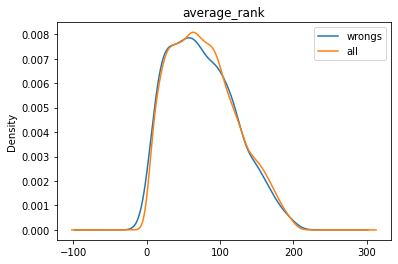

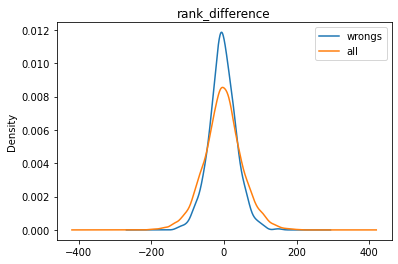

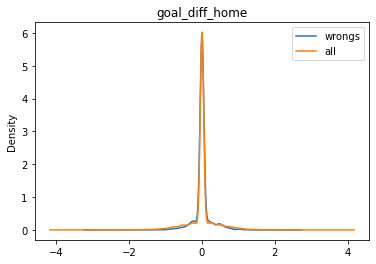

In [ ]:
features = ['average_rank', 'rank_difference',"goal_diff_home"]
wrongs = y_test != model.predict(X_test)

for feature in features:
    plt.figure()
    plt.title(feature)
    X_test.loc[wrongs, feature].plot.kde()
    X.loc[:, feature].plot.kde()
    plt.legend(['wrongs', 'all'])
    
print("Stakes distribution in the wrong predictions")
print(X_test.loc[wrongs, 'is_stake'].value_counts() / wrongs.sum())
print("Stakes distribution overall")
print(X['is_stake'].value_counts() / X.shape[0])
print("Show the diff in each column and where was the mistakes: ")

#example: we can see that in rank diff as the ranks more close to each other the more mistkaes was in the model

In [ ]:
#create dataframe of all the national teams in europe with theire games in the first round of the euro
euro_2020_rankings = rankings.loc[(rankings['rank_date'] == rankings['rank_date'].max()) &  rankings['country_full'].isin(euro_2020.index.unique())]
euro_2020_rankings = euro_2020_rankings.set_index(['country_full'])
print(euro_2020)

                Group  ... Third match\n against
Team                   ...                      
Italy               A  ...                 Wales
Switzerland         A  ...                Turkey
Turkey              A  ...                 Wales
Wales               A  ...                 Italy
Belgium             B  ...               Finland
Denmark             B  ...                Russia
Finland             B  ...               Belgium
Russia              B  ...               Denmark
Netherlands         C  ...       North Macedonia
North Macedonia     C  ...           Netherlands
Ukraine             C  ...               Austria
Austria             C  ...               Ukraine
Croatia             D  ...              Scotland
England             D  ...        Czech Republic
Scotland            D  ...               Croatia
Czech Republic      D  ...               England
Poland              E  ...                Sweden
Slovakia            E  ...                 Spain
Spain               

In [ ]:
#creating the predictions on the group stage of the euro:
#  we take each game and by the model that trained aboce we get the prob of each team to win the game, if the team win they get 3 points
#  else dont get nothing

from itertools import combinations

margin = 0.05

opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']

euro_2020['points'] = 0
euro_2020['total_prob'] = 0

for group in set(euro_2020['Group']):
    print('___Starting group {}:___'.format(group))
    for home, away in combinations(euro_2020.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = euro_2020_rankings.loc[home, 'rank']
        opp_rank = euro_2020_rankings.loc[away, 'rank']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['goal_diff_home'] = All_scores_new["Goals_avg"][home] - All_scores_new["Goals_avg"][away]

        # the model return the home team prob to win the game, it takes the average rank, rank diff goal diff and calculate the probabillity
        # taking the coefficents and intercept of the function and calculate the eqaution with 'row'
        home_win_prob = model.predict_proba(row)[:,1][0]
        euro_2020.loc[home, 'total_prob'] += home_win_prob
        euro_2020.loc[away, 'total_prob'] += 1-home_win_prob
        
        points = 0
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            euro_2020.loc[away, 'points'] += 3
        elif home_win_prob > 0.5 - margin and home_win_prob < 0.5 + margin :
            points = 1
            print("Draw")
            euro_2020.loc[home, 'points'] += 1
            euro_2020.loc[away, 'points'] += 1
        elif home_win_prob >= 0.5 + margin:
            points = 3
            euro_2020.loc[home, 'points'] += 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
            

print(euro_2020.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index())

___Starting group F:___
Portugal vs. France: Draw
Portugal vs. Germany: Draw
Portugal vs. Hungary: Portugal wins with 0.63
France vs. Germany: Draw
France vs. Hungary: France wins with 0.65
Germany vs. Hungary: Germany wins with 0.62
___Starting group D:___
Croatia vs. England: England wins with 0.57
Croatia vs. Scotland: Croatia wins with 0.63
Croatia vs. Czech Republic: Croatia wins with 0.60
England vs. Scotland: England wins with 0.70
England vs. Czech Republic: England wins with 0.68
Scotland vs. Czech Republic: Czech Republic wins with 0.56
___Starting group E:___
Poland vs. Slovakia: Poland wins with 0.57
Poland vs. Spain: Spain wins with 0.60
Poland vs. Sweden: Sweden wins with 0.55
Slovakia vs. Spain: Spain wins with 0.70
Slovakia vs. Sweden: Sweden wins with 0.66
Spain vs. Sweden: Spain wins with 0.55
___Starting group B:___
Belgium vs. Denmark: Draw
Belgium vs. Finland: Belgium wins with 0.76
Belgium vs. Russia: Belgium wins with 0.67
Denmark vs. Finland: Denmark wins with 0

In [ ]:
pairing = [0,5,1,3,2,12,4,13,14,8,6,11,7,9,10,15]



euro_2020 = euro_2020.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
next_round_wc = euro_2020.groupby('Group').nth([0, 1]) # select the top 2

######
#getting the 4 last national teams to the next rounds

last4 = euro_2020[euro_2020["Team"].isin(next_round_wc["Team"]) == False].sort_values("points")[8:12]
next_round_wc = next_round_wc.append(last4)
#######


next_round_wc = next_round_wc.reset_index()
next_round_wc = next_round_wc.reindex(index=pairing)##
next_round_wc = next_round_wc.set_index('Team')
finals = ['round_of_16', 'quarterfinal', 'semifinal', 'final']
labels = list()
odds = list()


for f in finals:
    print("___Starting of the {}___".format(f))
    iterations = int(len(next_round_wc) / 2)
    winners = []
    for i in range(iterations):
        home = next_round_wc.index[i*2]
        away = next_round_wc.index[i*2+1]
        print("{} vs. {}: ".format(home,
                                   away), 
                                   end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = euro_2020_rankings.loc[home, 'rank']
        opp_rank = euro_2020_rankings.loc[away, 'rank']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['goal_diff_home'] = All_scores_new["Goals_avg"][home] - All_scores_new["Goals_avg"][away]

        home_win_prob = model.predict_proba(row)[:,1][0]
        
        if model.predict_proba(row)[:,1] <= 0.5:
            print("{0} wins with probability {1:.2f}".format(away, 1-home_win_prob))
            winners.append(away)
        else:
            print("{0} wins with probability {1:.2f}".format(home, home_win_prob))
            winners.append(home)

        labels.append("{}({:.2f}) vs. {}({:.2f})".format(home, 
                                                        home_win_prob, 
                                                        away, 
                                                        1-home_win_prob))
        odds.append([home_win_prob, 1-home_win_prob])
    next_round_wc = next_round_wc.loc[winners]
    print("\n")

___Starting of the round_of_16___
Italy vs. Austria: Italy wins with probability 0.57
Switzerland vs. Denmark: Denmark wins with probability 0.54
Belgium vs. Ukraine: Belgium wins with probability 0.61
Netherlands vs. Russia: Netherlands wins with probability 0.61
Wales vs. Spain: Spain wins with probability 0.60
England vs. Portugal: England wins with probability 0.51
Croatia vs. Sweden: Sweden wins with probability 0.51
France vs. Germany: France wins with probability 0.54


___Starting of the quarterfinal___
Italy vs. Denmark: Italy wins with probability 0.51
Belgium vs. Netherlands: Belgium wins with probability 0.56
Spain vs. England: England wins with probability 0.52
Sweden vs. France: France wins with probability 0.58


___Starting of the semifinal___
Italy vs. Belgium: Belgium wins with probability 0.54
England vs. France: France wins with probability 0.51


___Starting of the final___
Belgium vs. France: Belgium wins with probability 0.50




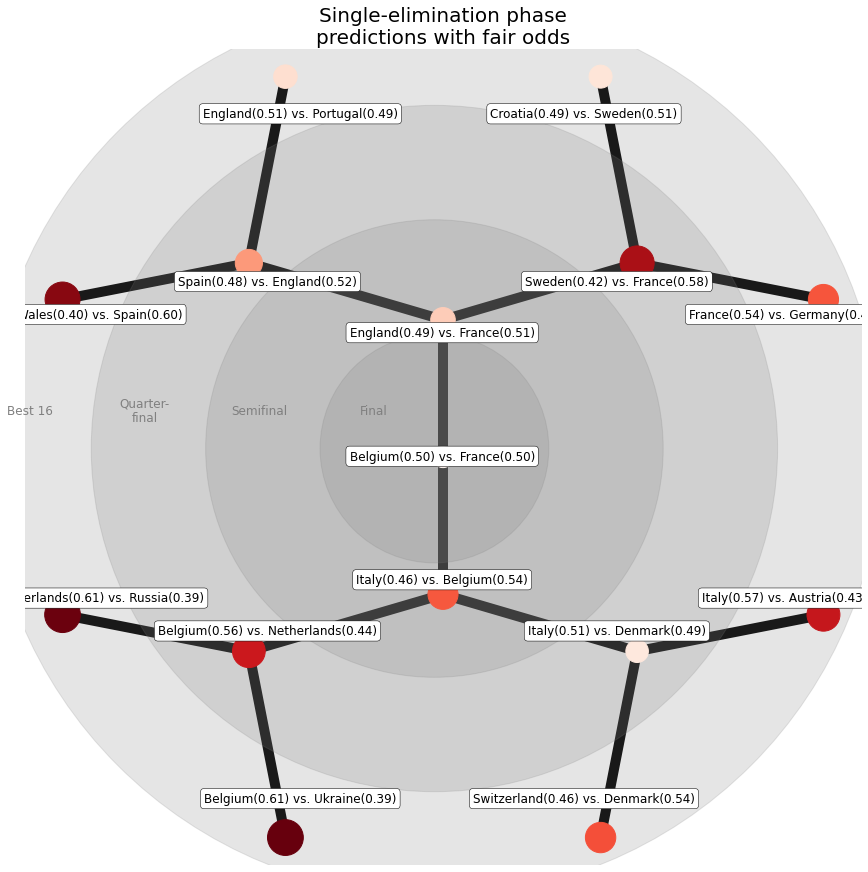

In [ ]:
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

node_sizes = pd.DataFrame(list(reversed(odds)))
scale_factor = 0.3 # for visualization
G = nx.balanced_tree(2, 3)
pos = graphviz_layout(G, prog='twopi')
centre = pd.DataFrame(pos).mean(axis=1).mean()

plt.figure(figsize=(15, 15))
ax = plt.subplot(1,1,1)
# add circles 
circle_positions = [(235, 'black'), (180, 'blue'), (120, 'red'), (60, 'yellow')]
[ax.add_artist(plt.Circle((centre, centre), 
                          cp, color='grey', 
                          alpha=0.2)) for cp, c in circle_positions]

# draw first the graph
nx.draw(G, pos, 
        node_color=node_sizes.diff(axis=1)[1].abs().pow(scale_factor), 
        node_size=node_sizes.diff(axis=1)[1].abs().pow(scale_factor)*2000, 
        alpha=1, 
        cmap='Reds',
        edge_color='black',
        width=10,
        with_labels=False)

# draw the custom node labels
shifted_pos = {k:[(v[0]-centre)*0.9+centre,(v[1]-centre)*0.9+centre] for k,v in pos.items()}
nx.draw_networkx_labels(G, 
                        pos=shifted_pos, 
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=dict(zip(reversed(range(len(labels))), labels)))

texts = ((10, 'Best 16', 'black'), (70, 'Quarter-\nfinal', 'blue'), (130, 'Semifinal', 'red'), (190, 'Final', 'yellow'))
[plt.text(p, centre+20, t, 
          fontsize=12, color='grey', 
          va='center', ha='center') for p,t,c in texts]
plt.axis('equal')
plt.title('Single-elimination phase\npredictions with fair odds', fontsize=20)
plt.show()

# Question 2 - 
### Predict if team qualified to the Euro tournament in history, by its total goal in matches and friendly matches and number of games historically – KNN

In [ ]:
# arrange in new dataframe all the data for the Knn - Goals scored over the years , number of game played and if the team qualify or not.
all_participents = pd.read_csv("/content/drive/MyDrive/Football_Data/Euro 1960 -2016/National Teams Appearance.csv")
all_participents = list(all_participents["Team"])

All_scores_new = pd.DataFrame(index = [str(x) for x in all_European_teams],columns = ["Goals","Games","Qualify"])
for i in range(len(All_scores_new)):
  All_scores_new["Goals"][all_European_teams[i]] = All_matches_result.loc[All_matches_result['away_team'] == all_European_teams[i], 'away_score'].sum() + All_matches_result.loc[All_matches_result['home_team'] == all_European_teams[i], 'home_score'].sum()
  All_scores_new["Games"][all_European_teams[i]] = All_matches_result.loc[All_matches_result['away_team'] == all_European_teams[i], 'away_team' ].count() + All_matches_result.loc[All_matches_result['home_team'] == all_European_teams[i],'home_team'].count() 
  All_scores_new["Qualify"][all_European_teams[i]] = 1 if all_European_teams[i] in all_participents else 0
print(All_scores_new["Goals"]["Albania"])


319.0


No handles with labels found to put in legend.


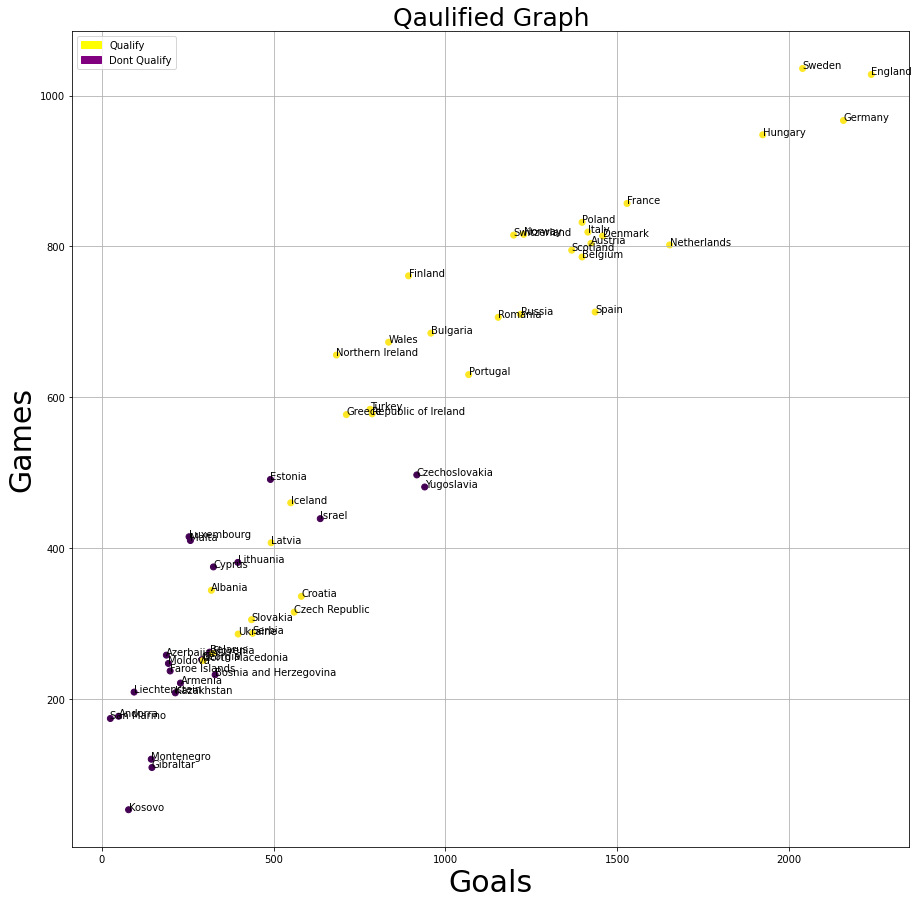

In [ ]:
import matplotlib.patches as mpatches
x_games = All_scores_new["Games"]
x_goals = All_scores_new["Goals"]

n = All_scores_new.index
fig, ax = plt.subplots()
fig.set_size_inches(15,15)

ax.scatter(x_goals, x_games,c = All_scores_new["Qualify"])
ax.set_xlabel("Goals", fontsize=30)
ax.set_ylabel("Games", fontsize=30)
ax.set_title('Qaulified Graph',fontsize=25)
ax.legend()
ax.grid(True)


for i, txt in enumerate(n):
    ax.annotate(txt, (x_goals[i], x_games[i]),fontsize=10)

yellow_patch = mpatches.Patch(color='yellow', label='Qualify')
purple_patch = mpatches.Patch(color='purple', label='Dont Qualify')
plt.legend(handles=[yellow_patch,purple_patch],loc = 'upper left')
plt.show()

In [ ]:
All_scores_new.describe()

,Goals,Games,Qualify
count,57.0,57,57
unique,56.0,57,2
top,1398.0,381,1
freq,2.0,1,35


the score of the model on the test with 1 neigh is:0.9  
the score of the model on the train with 1 neigh is:1.0  
the score of the model on the test with 3 neigh is:0.8  
the score of the model on the train with 3 neigh is:0.8648648648648649  
the score of the model on the test with 5 neigh is:0.8  
the score of the model on the train with 5 neigh is:0.8378378378378378  
the score of the model on the test with 7 neigh is:0.85  
the score of the model on the train with 7 neigh is:0.8378378378378378  
the score of the model on the test with 9 neigh is:0.85  
the score of the model on the train with 9 neigh is:0.8378378378378378  
the score of the model on the test with 11 neigh is:0.85  
the score of the model on the train with 11 neigh is:0.8648648648648649  
[ 1  3  5  7  9 11]
[0.9  0.8  0.8  0.85 0.85 0.85]


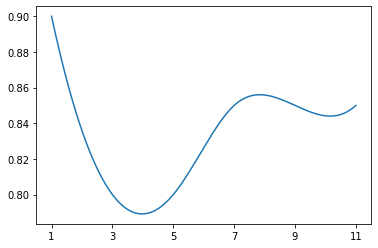

[ 1  3  5  7  9 11]
[1.         0.86486486 0.83783784 0.83783784 0.83783784 0.86486486]


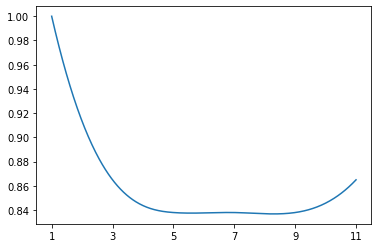

In [ ]:
from scipy.interpolate import make_interp_spline
import numpy as np

#creating the model  X = with the test set of the amount of goals and games each team played
#                    Y = all the Qaulified labels of each team
x_train, x_test, y_train, y_test = train_test_split(All_scores_new[["Goals","Games"]].to_numpy().astype("int"),All_scores_new[["Qualify"]].to_numpy().astype("int"), test_size=0.35, random_state=42) 

error_test = []
error_train = []
for k in range(1,13,2):
  neigh = KNeighborsClassifier(n_neighbors=k)

  #train the model on the train data of 75% of the teams
  neigh.fit(x_train, y_train.ravel())

  #doing prediction on the test set
  y_pred = neigh.predict(x_test)

  #print the score of the model on the test set
  print(f"the score of the model on the test with {k} neigh is:{neigh.score(x_test,y_test.ravel())}  ")
  error_test.append(neigh.score(x_test,y_test.ravel()))
  
  # print the score of the model on the train set
  print(f"the score of the model on the train with {k} neigh is:{neigh.score(x_train,y_train.ravel())}  ")
  error_train.append(neigh.score(x_train,y_train.ravel()))

#plotting the test error graph
y = np.array(error_test)
x = np.array([x for x in range(1,13,2)])
print(x)
print(y)
X_Y_Spline = make_interp_spline(x, y)
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_Spline(X_)
plt.plot(X_,Y_)
plt.xticks(x)
plt.show()

#plotting the test error graph
y = np.array(error_train)
x = np.array([x for x in range(1,13,2)])
print(x)
print(y)
X_Y_Spline = make_interp_spline(x, y)
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_Spline(X_)
plt.plot(X_,Y_)
plt.xticks(x)
plt.show()


In [ ]:
#save all the names of the teams to list
x_test_teams_names = []
for goals,games in x_test:
  x_test_teams_names.append(All_scores_new.loc[(All_scores_new["Goals"] == goals) & (All_scores_new["Games"] == games) ]["Games"].index[0] )

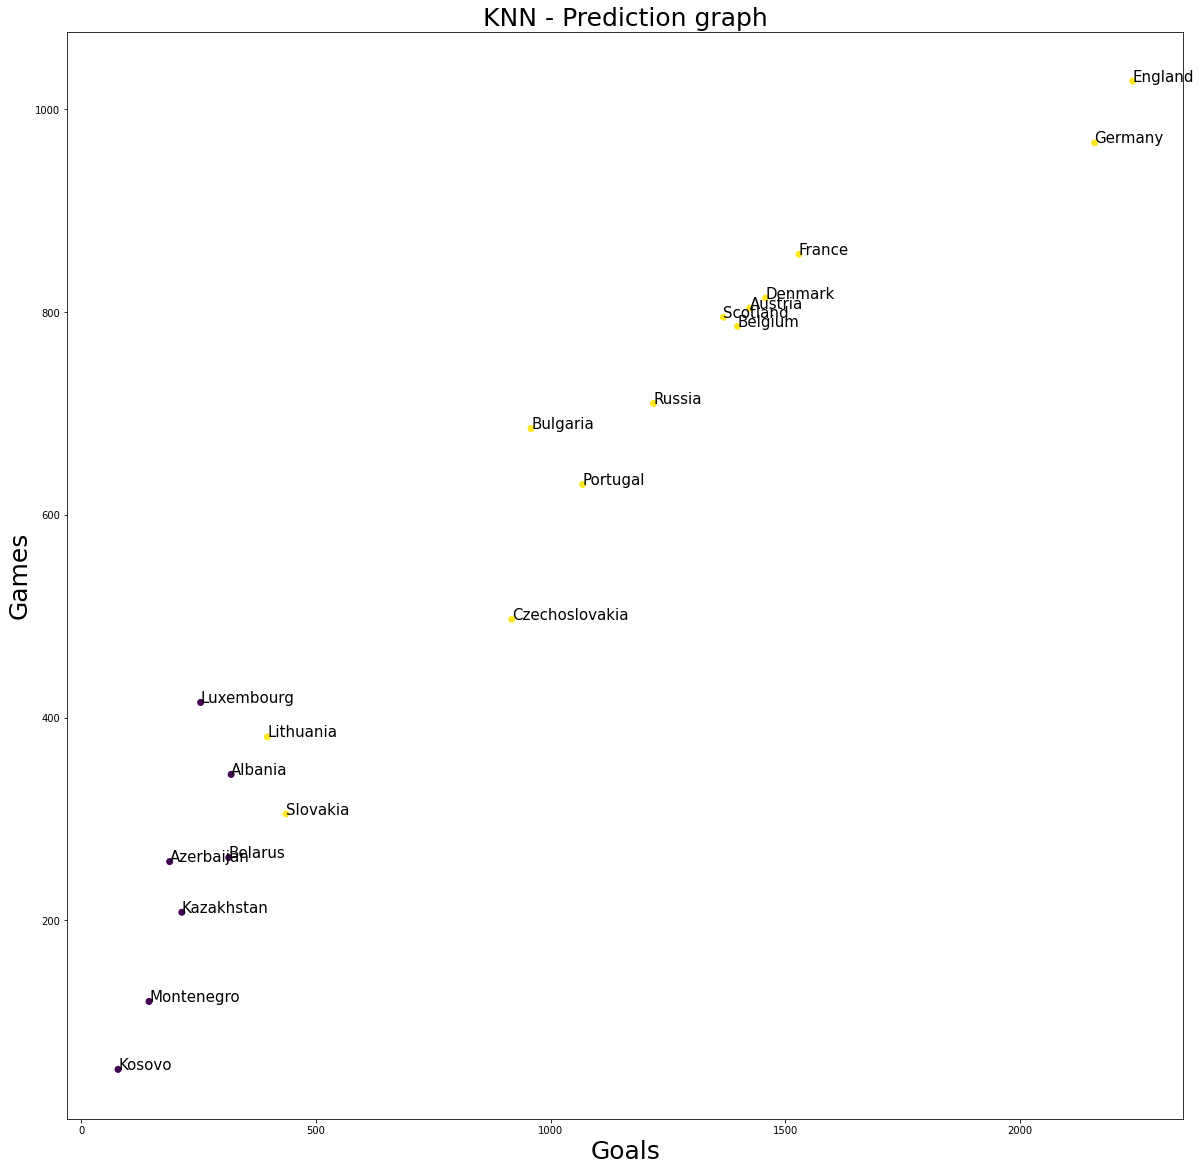

In [ ]:
# y-axis -> games
x_games = [x[1] for x in x_test]
# x-axis -> goals
x_goals = [x[0] for x in x_test]
# labels for all the names of the teams
n = x_test_teams_names

#plot the graph of all the teams
fig, ax = plt.subplots()
fig.set_size_inches(20,20)

ax.scatter(x_goals, x_games,c = y_pred)
ax.set_xlabel("Goals", fontsize=25)
ax.set_ylabel("Games", fontsize=25)
ax.set_title('KNN - Prediction graph',fontsize=25)
for i, txt in enumerate(n):
    ax.annotate(txt, (x_goals[i], x_games[i]),fontsize=15)

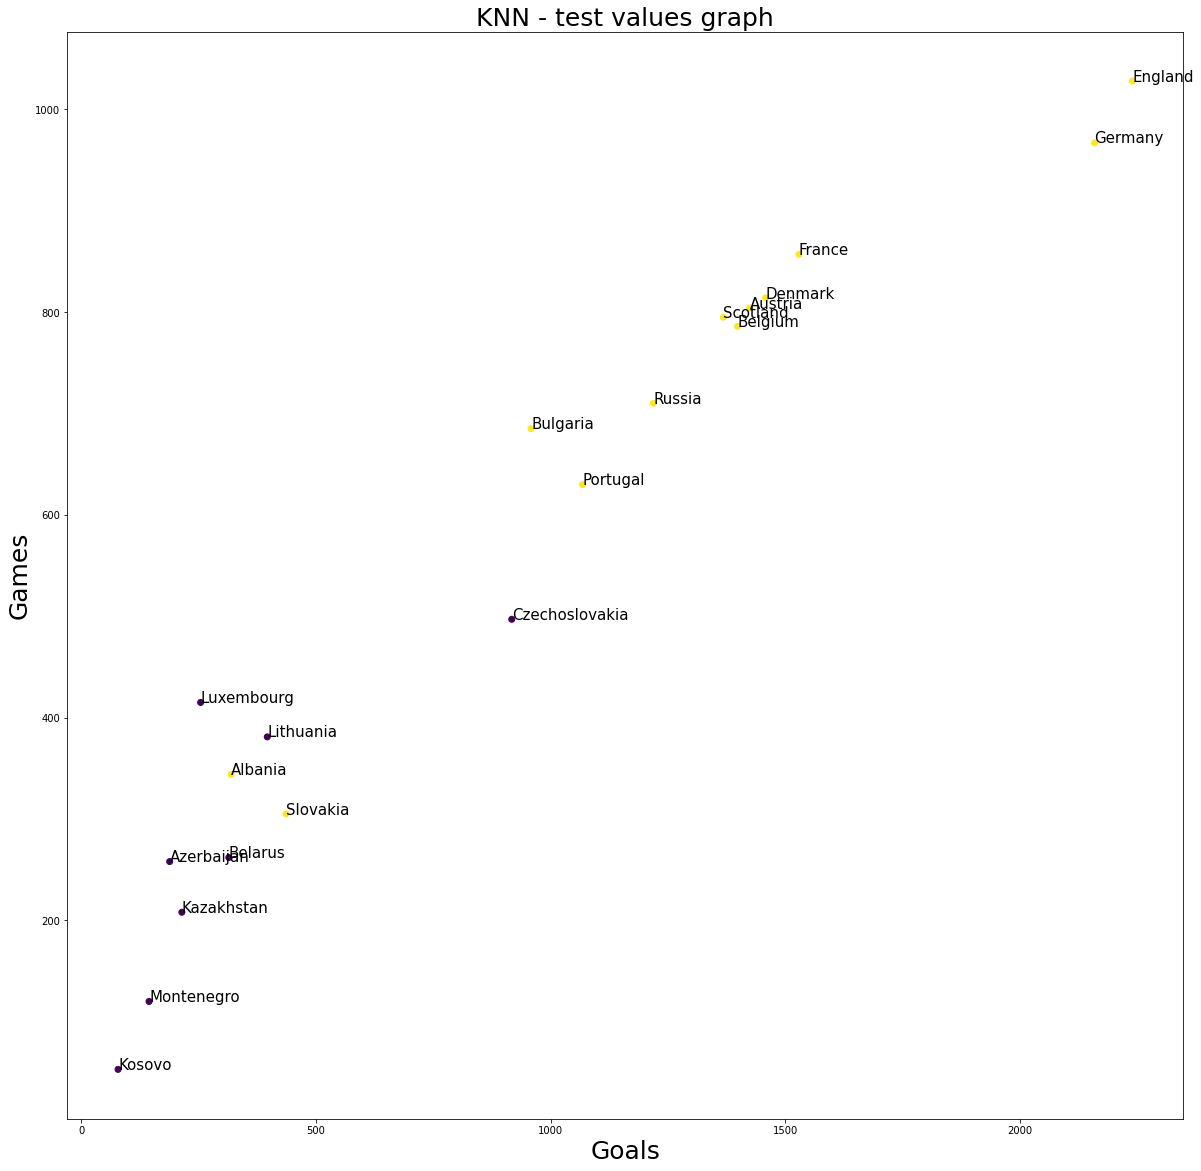

In [ ]:
# y-axis -> games
x_games = [x[1] for x in x_test]
# x-axis -> goals
x_goals = [x[0] for x in x_test]
# labels for all the names of the teams
n = x_test_teams_names

#plot the graph of all the teams
fig, ax = plt.subplots()
fig.set_size_inches(20,20)

ax.scatter(x_goals, x_games,c = y_test)
ax.set_xlabel("Goals", fontsize=25)
ax.set_ylabel("Games", fontsize=25)
ax.set_title('KNN - test values graph',fontsize=25)
for i, txt in enumerate(n):
    ax.annotate(txt, (x_goals[i], x_games[i]),fontsize=15)

#Quesion 3 - 
##classify all the Euro players to thiere position by the values of their values
## Kmeans 

In [ ]:
players_data = pd.read_csv("/content/drive/MyDrive/Football_Data/FIFA20/players_20.csv")
euro_players = pd.read_csv("/content/drive/MyDrive/Football_Data/FIFA20/international-uefa-euro-championship-players-2020-to-2021-stats (1).csv")

In [ ]:
players_data = players_data.loc[players_data['long_name'].isin(euro_players['full_name'])]

In [ ]:
players = players_data[['short_name','age', 'height_cm', 'weight_kg', 'overall', 'potential','value_eur', 'wage_eur', 'international_reputation', 'weak_foot','skill_moves', 'release_clause_eur', 'pace', 'shooting','passing', 'dribbling', 'defending', 'physic', 'gk_diving','gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed','gk_positioning', 'attacking_crossing', 'attacking_finishing','attacking_heading_accuracy', 'attacking_short_passing','attacking_volleys', 'skill_dribbling', 'skill_curve','skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control','movement_acceleration', 'movement_sprint_speed', 'movement_agility','movement_reactions', 'movement_balance', 'power_shot_power','power_jumping', 'power_stamina', 'power_strength', 'power_long_shots','mentality_aggression', 'mentality_interceptions','mentality_positioning', 'mentality_vision', 'mentality_penalties','mentality_composure', 'defending_marking', 'defending_standing_tackle','defending_sliding_tackle', 'goalkeeping_diving','goalkeeping_handling', 'goalkeeping_kicking','goalkeeping_positioning', 'goalkeeping_reflexes']]

In [ ]:
players = players[players.overall > 70]
players = players.fillna(players.mean())
players

,short_name,age,height_cm,weight_kg,overall,potential,value_eur,wage_eur,international_reputation,weak_foot,skill_moves,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
4,E. Hazard,28,175,74,91,91,90000000,470000,4,4,4,1.845000e+08,91.000000,83.00,86.000000,94.00000,35.00000,66.00000,77.727273,74.654545,71.272727,79.327273,45.018182,76.236364,81,84,61,89,83,95,83,79,83,94,94,88,95,90,94,82,56,84,63,80,54,41,87,89,88,91,34,27,22,11,12,6,8,8
5,K. De Bruyne,28,181,70,91,91,90000000,370000,4,5,4,1.665000e+08,76.000000,86.00,92.000000,86.00000,61.00000,78.00000,77.727273,74.654545,71.272727,79.327273,45.018182,76.236364,93,82,55,92,82,86,85,83,91,91,77,76,78,91,76,91,63,89,74,90,76,61,88,94,79,91,68,58,51,15,13,5,10,13
8,L. Modrić,33,172,66,90,90,45000000,340000,4,4,4,9.230000e+07,74.000000,76.00,89.000000,89.00000,72.00000,66.00000,77.727273,74.654545,71.272727,79.327273,45.018182,76.236364,86,72,55,92,76,87,85,78,88,92,77,71,92,89,93,79,68,85,58,82,62,82,79,91,82,92,68,76,71,13,9,7,14,9
10,K. Mbappé,20,178,73,89,95,93500000,155000,3,4,5,1.917000e+08,96.000000,84.00,78.000000,90.00000,39.00000,75.00000,77.727273,74.654545,71.272727,79.327273,45.018182,76.236364,78,89,77,82,79,91,79,63,70,90,96,96,92,89,83,83,76,84,76,79,62,38,89,80,70,84,34,34,32,13,5,7,11,6
12,H. Kane,25,188,89,89,91,83000000,220000,3,4,3,1.598000e+08,70.000000,91.00,79.000000,81.00000,47.00000,83.00000,77.727273,74.654545,71.272727,79.327273,45.018182,76.236364,75,94,86,81,85,80,78,68,83,84,68,72,71,91,73,90,79,87,84,86,78,35,93,81,90,91,56,36,38,8,10,11,14,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4513,D. Kuciak,34,194,87,71,71,1000000,5000,1,2,1,1.400000e+06,72.571875,64.35,70.146875,73.79375,62.11875,72.48125,75.000000,64.000000,62.000000,77.000000,36.000000,71.000000,11,11,11,21,11,11,11,11,14,24,41,32,39,64,44,47,70,36,70,11,34,17,13,44,13,59,15,11,11,75,64,62,71,77
4524,J. McLaughlin,31,188,83,71,71,1500000,7000,1,3,1,2.700000e+06,72.571875,64.35,70.146875,73.79375,62.11875,72.48125,70.000000,73.000000,72.000000,69.000000,55.000000,72.000000,21,20,14,27,13,16,15,21,41,23,57,54,62,65,63,54,60,37,68,19,41,18,17,46,26,52,24,17,14,70,73,72,72,69
4583,R. Varga,29,182,79,71,71,0,0,1,4,3,3.207407e+07,82.000000,68.00,67.000000,71.00000,32.00000,68.00000,77.727273,74.654545,71.272727,79.327273,45.018182,76.236364,70,66,69,69,67,70,72,77,53,71,84,80,74,68,69,71,81,72,68,69,62,25,72,67,63,73,34,28,18,15,13,9,11,10
4612,P. Pervan,31,194,92,71,71,1500000,19000,1,4,1,2.600000e+06,72.571875,64.35,70.146875,73.79375,62.11875,72.48125,68.000000,73.000000,69.000000,75.000000,29.000000,70.000000,19,9,15,22,8,14,15,14,31,15,32,27,36,63,33,52,44,23,54,15,28,15,5,31,14,30,16,21,19,68,73,69,70,75


In [ ]:
from sklearn.preprocessing import MinMaxScaler

players.set_index(players['short_name'])
names = players['short_name'].tolist()
players = players.drop(columns=['short_name'])
x = players.values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(x)
X_normalized = pd.DataFrame(X_scaled)
X_normalized

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56
0,0.555556,0.315789,0.365854,1.00,0.833333,0.962567,1.000000,0.75,0.75,0.75,0.962185,0.919355,0.884058,0.877551,1.000000,0.140625,0.452381,0.442149,0.448252,0.589015,0.469421,0.537029,0.484492,0.857143,0.882353,0.614458,0.961538,0.939759,1.000000,0.891566,0.857143,0.8875,1.000000,0.957746,0.894737,1.000000,0.914286,0.973333,0.863636,0.419355,0.833333,0.457627,0.880952,0.493333,0.370370,0.931818,0.934211,0.974684,0.940299,0.310345,0.219512,0.151899,0.102273,0.114943,0.044944,0.072289,0.056818
1,0.555556,0.473684,0.268293,1.00,0.833333,0.962567,0.787234,0.75,1.00,0.75,0.867647,0.677419,0.927536,1.000000,0.857143,0.546875,0.738095,0.442149,0.448252,0.589015,0.469421,0.537029,0.484492,1.000000,0.858824,0.542169,1.000000,0.927711,0.894118,0.915663,0.904762,0.9875,0.963415,0.718310,0.736842,0.770270,0.942857,0.733333,1.000000,0.532258,0.897436,0.644068,1.000000,0.786667,0.617284,0.943182,1.000000,0.860759,0.940299,0.701149,0.597561,0.518987,0.147727,0.126437,0.033708,0.096386,0.113636
2,0.833333,0.236842,0.170732,0.95,0.791667,0.481283,0.723404,0.75,0.75,0.75,0.477941,0.645161,0.782609,0.938776,0.910714,0.718750,0.452381,0.442149,0.448252,0.589015,0.469421,0.537029,0.484492,0.916667,0.741176,0.542169,1.000000,0.855422,0.905882,0.915663,0.845238,0.9500,0.975610,0.718310,0.671053,0.959459,0.885714,0.960000,0.818182,0.612903,0.846154,0.372881,0.904762,0.600000,0.876543,0.840909,0.960526,0.898734,0.955224,0.701149,0.817073,0.772152,0.125000,0.080460,0.056180,0.144578,0.068182
3,0.111111,0.394737,0.341463,0.90,1.000000,1.000000,0.329787,0.50,0.75,1.00,1.000000,1.000000,0.898551,0.714286,0.928571,0.203125,0.666667,0.442149,0.448252,0.589015,0.469421,0.537029,0.484492,0.821429,0.941176,0.807229,0.871795,0.891566,0.952941,0.843373,0.666667,0.7250,0.951220,0.985915,1.000000,0.959459,0.885714,0.826667,0.878788,0.741935,0.833333,0.677966,0.869048,0.600000,0.333333,0.954545,0.815789,0.746835,0.835821,0.310345,0.304878,0.278481,0.125000,0.034483,0.056180,0.108434,0.034091
4,0.388889,0.657895,0.731707,0.90,0.833333,0.887701,0.468085,0.50,0.75,0.50,0.832458,0.580645,1.000000,0.734694,0.767857,0.328125,0.857143,0.442149,0.448252,0.589015,0.469421,0.537029,0.484492,0.785714,1.000000,0.915663,0.858974,0.963855,0.823529,0.831325,0.726190,0.8875,0.878049,0.591549,0.684211,0.675676,0.942857,0.693333,0.984848,0.790323,0.871795,0.813559,0.952381,0.813333,0.296296,1.000000,0.828947,1.000000,0.940299,0.563218,0.329268,0.354430,0.068182,0.091954,0.101124,0.144578,0.090909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,0.888889,0.815789,0.682927,0.00,0.000000,0.010695,0.010638,0.00,0.25,0.00,0.000525,0.622127,0.613768,0.554018,0.639174,0.564355,0.606696,0.318182,0.038462,0.395833,0.363636,0.317073,0.176471,0.023810,0.023529,0.012048,0.089744,0.072289,0.011765,0.024096,0.047619,0.0250,0.146341,0.211268,0.157895,0.243243,0.171429,0.306667,0.333333,0.645161,0.217949,0.576271,0.059524,0.226667,0.074074,0.090909,0.342105,0.025316,0.462687,0.091954,0.024390,0.012658,0.829545,0.712644,0.674157,0.831325,0.840909
371,0.722222,0.657895,0.585366,0.00,0.000000,0.016043,0.014894,0.00,0.50,0.00,0.007353,0.622127,0.613768,0.554018,0.639174,0.564355,0.606696,0.090909,0.384615,0.604167,0.000000,0.780488,0.235294,0.142857,0.129412,0.048193,0.166667,0.096386,0.070588,0.072289,0.166667,0.3625,0.134146,0.436620,0.447368,0.554054,0.200000,0.560000,0.439394,0.483871,0.230769,0.542373,0.154762,0.320000,0.086420,0.136364,0.368421,0.189873,0.358209,0.195402,0.097561,0.050633,0.772727,0.816092,0.786517,0.843373,0.750000
372,0.611111,0.500000,0.487805,0.00,0.000000,0.000000,0.000000,0.00,0.75,0.50,0.161629,0.774194,0.666667,0.489796,0.589286,

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2) 
pca.fit(X_normalized)

print('Variance of each component:', pca.explained_variance_ratio_)
print('\n Total Variance Explained:', round(sum(list(pca.explained_variance_ratio_))*100, 2))

X_reduced = pd.DataFrame(pca.transform(X_normalized))
X_reduced

Variance of each component: [0.52495579 0.16607816]

 Total Variance Explained: 69.1


,0,1
0,-1.256818,1.552306
1,-1.429276,0.762566
2,-1.381873,0.427690
3,-1.200471,1.262150
4,-1.059601,0.806335
...,...,...
370,2.916513,0.129144
371,2.481835,0.268006
372,-0.203991,0.753091
373,2.971373,0.100127


In [ ]:
from sklearn.cluster import KMeans

# number of clusters
kmeans = KMeans(n_clusters=5)
kmeans = kmeans.fit(X_reduced)
labels = kmeans.predict(X_reduced)
clusters_lable = kmeans.labels_.tolist()


In [ ]:
X_reduced['cluster'] = clusters_lable
X_reduced['name'] = names
X_reduced.columns = ['x', 'y', 'cluster', 'name']

In [ ]:
import plotly.express as px
import pandas as pd

fig = px.scatter(X_reduced, x="x", y="y", color="cluster",hover_name="name")
fig.show()

#Random forest - enother way of solving this problem with random forest

In [ ]:
players_data = pd.read_csv("/content/drive/MyDrive/Football_Data/FIFA20/players_20.csv")
players_data

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,...,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,32,1987-06-24,170,72,Argentina,FC Barcelona,94,94,95500000,565000,"RW, CF, ST",Left,5,4,4,Medium/Low,Messi,Yes,195800000.0,"#Dribbler, #Distance Shooter, #Crosser, #FK Sp...",RW,10.0,NaN,2004-07-01,2021.0,NaN,NaN,87.0,92.0,92.0,96.0,39.0,66.0,NaN,NaN,NaN,...,48,40,94,94,75,96,33,37,26,6,11,15,14,8,89+2,89+2,89+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,92+2,87+2,87+2,87+2,92+2,68+2,66+2,66+2,66+2,68+2,63+2,52+2,52+2,52+2,63+2
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,1985-02-05,187,83,Portugal,Juventus,93,93,58500000,405000,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,Yes,96500000.0,"#Speedster, #Dribbler, #Distance Shooter, #Acr...",LW,7.0,NaN,2018-07-10,2022.0,LS,7.0,90.0,93.0,82.0,89.0,35.0,78.0,NaN,NaN,NaN,...,63,29,95,82,85,95,28,32,24,7,11,15,14,11,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,27,1992-02-05,175,68,Brazil,Paris Saint-Germain,92,92,105500000,290000,"LW, CAM",Right,5,5,5,High/Medium,Neymar,Yes,195200000.0,"#Speedster, #Dribbler, #Playmaker , #Crosser,...",CAM,10.0,NaN,2017-08-03,2022.0,LW,10.0,91.0,85.0,87.0,95.0,32.0,58.0,NaN,NaN,NaN,...,51,36,87,90,90,94,27,26,29,9,9,15,15,11,84+3,84+3,84+3,90+3,89+3,89+3,89+3,90+3,90+3,90+3,90+3,89+3,82+3,82+3,82+3,89+3,66+3,61+3,61+3,61+3,66+3,61+3,46+3,46+3,46+3,61+3
3,200389,https://sofifa.com/player/200389/jan-oblak/20/...,J. Oblak,Jan Oblak,26,1993-01-07,188,87,Slovenia,Atlético Madrid,91,93,77500000,125000,GK,Right,3,3,1,Medium/Medium,Normal,Yes,164700000.0,NaN,GK,13.0,NaN,2014-07-16,2023.0,GK,1.0,NaN,NaN,NaN,NaN,NaN,NaN,87.0,92.0,78.0,...,34,19,11,65,11,68,27,12,18,87,92,78,90,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,183277,https://sofifa.com/player/183277/eden-hazard/2...,E. Hazard,Eden Hazard,28,1991-01-07,175,74,Belgium,Real Madrid,91,91,90000000,470000,"LW, CF",Right,4,4,4,High/Medium,Normal,Yes,184500000.0,"#Speedster, #Dribbler, #Acrobat",LW,7.0,NaN,2019-07-01,2024.0,LF,10.0,91.0,83.0,86.0,94.0,35.0,66.0,NaN,NaN,NaN,...,54,41,87,89,88,91,34,27,22,11,12,6,8,8,83+3,83+3,83+3,89+3,88+3,88+3,88+3,89+3,89+3,89+3,89+3,89+3,83+3,83+3,83+3,89+3,66+3,63+3,63+3,63+3,66+3,61+3,49+3,49+3,49+3,61+3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18273,245006,https://sofifa.com/player/245006/shuai-shao/20...,Shao Shuai,邵帅,22,1997-03-10,186,79,China PR,Beijing Renhe FC,48,56,40000,2000,CB,Right,1,3,2,Medium/High,Normal,No,70000.0,NaN,RES,36.0,NaN,2018-07-13,2019.0,NaN,NaN,57.0,23.0,28.0,33.0,47.0,51.0,NaN,NaN,NaN,...,46,48,28,25,39,41,45,50,52,5,5,13,5,14,

In [ ]:
from sklearn.ensemble import RandomForestClassifier

players_data = pd.read_csv("/content/drive/MyDrive/Football_Data/FIFA20/players_20.csv")

players_data = players_data.loc[players_data['long_name'].isin(euro_players['full_name'])]
players_data = players_data.reset_index()
players_data["clusters"] = 0



for i in range(len(players_data)):
  if players_data["team_position"].iloc[i] in ["GK"]:
    players_data["clusters"].iloc[i] = 1
  elif players_data["team_position"].iloc[i] in ["CB","LB","LCB","RCB","LWB","RB","RWB"]:
    players_data["clusters"].iloc[i] = 2
  elif players_data["team_position"].iloc[i] in ["CDM","CM","LCM","RCM","RM","RL","RDM","LDM"]:
    players_data["clusters"].iloc[i] = 3
  elif players_data["team_position"].iloc[i] in ["CAM","RW","LW"]:
    players_data["clusters"].iloc[i] = 4
  elif players_data["team_position"].iloc[i] in ["CF","ST"]:
    players_data["clusters"].iloc[i] = 5

# cutting only the relevance columns for the algo
players_data = players_data[['age', 'height_cm', 'weight_kg', 'overall', 'potential','value_eur', 'wage_eur', 'international_reputation', 'weak_foot','skill_moves', 'release_clause_eur', 'attacking_crossing', 'attacking_finishing','attacking_heading_accuracy', 'attacking_short_passing','attacking_volleys', 'skill_dribbling', 'skill_curve','skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control','movement_acceleration', 'movement_sprint_speed', 'movement_agility','movement_reactions', 'movement_balance', 'power_shot_power','power_jumping', 'power_stamina', 'power_strength', 'power_long_shots','mentality_aggression', 'mentality_interceptions','mentality_positioning', 'mentality_vision', 'mentality_penalties','mentality_composure', 'defending_marking', 'defending_standing_tackle','defending_sliding_tackle', 'goalkeeping_diving','goalkeeping_handling', 'goalkeeping_kicking','goalkeeping_positioning', 'goalkeeping_reflexes',"clusters"]]


players_data = players_data.where(players_data["clusters"] != 0)
players_data = players_data.dropna()
players_data.reset_index()

#creating y array of all the true clusters of the players
Y = np.array(players_data["clusters"])
players_data = players_data.drop(columns=["clusters"])

#split the data to train test with 65% train 35% test.
x_train, x_test, y_train, y_test = train_test_split(players_data,Y, test_size=0.35, random_state=42) 

#create the random forest classifier and run the algo on the train and test classes
clf = RandomForestClassifier()
clf.fit(x_train,y_train)
score = clf.score(x_test,y_test)

#print the score of the classification of the algo on the test class
print(score)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0.8539325842696629


In [ ]:
#creating a table of prediction and true results of the algo
final_table = pd.DataFrame(columns=["True","Predict"])
Y_pred = clf.predict(x_test)
final_table["Predict"] = Y_pred
final_table["True"] = y_test


number_errors_0 = final_table.groupby(final_table["True"]).count()
number_predict_error_0 = final_table.groupby(final_table["Predict"]).count()
final_table["True"] = number_errors_0
final_table["Predict"]= number_predict_error_0
final_table = final_table.dropna()
final_table

,True,Predict
1,14.0,14.0
2,32.0,38.0
3,34.0,29.0
4,5.0,1.0
5,4.0,7.0


#Question 4 - 
## using linear regression to predict the best 11 players from attributes that fit to theire position on the field

###the formation is 4 - 4 - 2 :
- 4 defenders 
- 4 midfielders
- 2 strikers

In [ ]:
#upload the csv of all players attributes, up to date.
players_ratings = pd.read_csv("/content/drive/MyDrive/Football_Data/FIFA20/players_20.csv")
the_best_players = []# list to save the best players in each position
players_ratings

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,...,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,32,1987-06-24,170,72,Argentina,FC Barcelona,94,94,95500000,565000,"RW, CF, ST",Left,5,4,4,Medium/Low,Messi,Yes,195800000.0,"#Dribbler, #Distance Shooter, #Crosser, #FK Sp...",RW,10.0,NaN,2004-07-01,2021.0,NaN,NaN,87.0,92.0,92.0,96.0,39.0,66.0,NaN,NaN,NaN,...,48,40,94,94,75,96,33,37,26,6,11,15,14,8,89+2,89+2,89+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,92+2,87+2,87+2,87+2,92+2,68+2,66+2,66+2,66+2,68+2,63+2,52+2,52+2,52+2,63+2
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,1985-02-05,187,83,Portugal,Juventus,93,93,58500000,405000,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,Yes,96500000.0,"#Speedster, #Dribbler, #Distance Shooter, #Acr...",LW,7.0,NaN,2018-07-10,2022.0,LS,7.0,90.0,93.0,82.0,89.0,35.0,78.0,NaN,NaN,NaN,...,63,29,95,82,85,95,28,32,24,7,11,15,14,11,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,27,1992-02-05,175,68,Brazil,Paris Saint-Germain,92,92,105500000,290000,"LW, CAM",Right,5,5,5,High/Medium,Neymar,Yes,195200000.0,"#Speedster, #Dribbler, #Playmaker , #Crosser,...",CAM,10.0,NaN,2017-08-03,2022.0,LW,10.0,91.0,85.0,87.0,95.0,32.0,58.0,NaN,NaN,NaN,...,51,36,87,90,90,94,27,26,29,9,9,15,15,11,84+3,84+3,84+3,90+3,89+3,89+3,89+3,90+3,90+3,90+3,90+3,89+3,82+3,82+3,82+3,89+3,66+3,61+3,61+3,61+3,66+3,61+3,46+3,46+3,46+3,61+3
3,200389,https://sofifa.com/player/200389/jan-oblak/20/...,J. Oblak,Jan Oblak,26,1993-01-07,188,87,Slovenia,Atlético Madrid,91,93,77500000,125000,GK,Right,3,3,1,Medium/Medium,Normal,Yes,164700000.0,NaN,GK,13.0,NaN,2014-07-16,2023.0,GK,1.0,NaN,NaN,NaN,NaN,NaN,NaN,87.0,92.0,78.0,...,34,19,11,65,11,68,27,12,18,87,92,78,90,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,183277,https://sofifa.com/player/183277/eden-hazard/2...,E. Hazard,Eden Hazard,28,1991-01-07,175,74,Belgium,Real Madrid,91,91,90000000,470000,"LW, CF",Right,4,4,4,High/Medium,Normal,Yes,184500000.0,"#Speedster, #Dribbler, #Acrobat",LW,7.0,NaN,2019-07-01,2024.0,LF,10.0,91.0,83.0,86.0,94.0,35.0,66.0,NaN,NaN,NaN,...,54,41,87,89,88,91,34,27,22,11,12,6,8,8,83+3,83+3,83+3,89+3,88+3,88+3,88+3,89+3,89+3,89+3,89+3,89+3,83+3,83+3,83+3,89+3,66+3,63+3,63+3,63+3,66+3,61+3,49+3,49+3,49+3,61+3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18273,245006,https://sofifa.com/player/245006/shuai-shao/20...,Shao Shuai,邵帅,22,1997-03-10,186,79,China PR,Beijing Renhe FC,48,56,40000,2000,CB,Right,1,3,2,Medium/High,Normal,No,70000.0,NaN,RES,36.0,NaN,2018-07-13,2019.0,NaN,NaN,57.0,23.0,28.0,33.0,47.0,51.0,NaN,NaN,NaN,...,46,48,28,25,39,41,45,50,52,5,5,13,5,14,

In [ ]:
#we use this only for filtering the relevant players from FIFA20 database
euro_players = pd.read_csv("/content/drive/MyDrive/Football_Data/FIFA20/international-uefa-euro-championship-players-2020-to-2021-stats (1).csv")

In [ ]:
# filter the players
players_ratings = players_ratings.loc[players_ratings['long_name'].isin(euro_players['full_name'])]

In [ ]:
players_ratings

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,...,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
4,183277,https://sofifa.com/player/183277/eden-hazard/2...,E. Hazard,Eden Hazard,28,1991-01-07,175,74,Belgium,Real Madrid,91,91,90000000,470000,"LW, CF",Right,4,4,4,High/Medium,Normal,Yes,184500000.0,"#Speedster, #Dribbler, #Acrobat",LW,7.0,NaN,2019-07-01,2024.0,LF,10.0,91.0,83.0,86.0,94.0,35.0,66.0,NaN,NaN,NaN,...,54,41,87,89,88,91,34,27,22,11,12,6,8,8,83+3,83+3,83+3,89+3,88+3,88+3,88+3,89+3,89+3,89+3,89+3,89+3,83+3,83+3,83+3,89+3,66+3,63+3,63+3,63+3,66+3,61+3,49+3,49+3,49+3,61+3
5,192985,https://sofifa.com/player/192985/kevin-de-bruy...,K. De Bruyne,Kevin De Bruyne,28,1991-06-28,181,70,Belgium,Manchester City,91,91,90000000,370000,"CAM, CM",Right,4,5,4,High/High,Normal,Yes,166500000.0,"#Dribbler, #Playmaker , #Engine, #Distance Sh...",RCM,17.0,NaN,2015-08-30,2023.0,RCM,7.0,76.0,86.0,92.0,86.0,61.0,78.0,NaN,NaN,NaN,...,76,61,88,94,79,91,68,58,51,15,13,5,10,13,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,87+3,87+3,88+3,77+3,77+3,77+3,77+3,77+3,73+3,66+3,66+3,66+3,73+3
8,177003,https://sofifa.com/player/177003/luka-modric/2...,L. Modrić,Luka Modrić,33,1985-09-09,172,66,Croatia,Real Madrid,90,90,45000000,340000,CM,Right,4,4,4,High/High,Lean,Yes,92300000.0,"#Dribbler, #Playmaker , #Crosser, #Acrobat, #...",RCM,10.0,NaN,2012-08-01,2020.0,NaN,NaN,74.0,76.0,89.0,89.0,72.0,66.0,NaN,NaN,NaN,...,62,82,79,91,82,92,68,76,71,13,9,7,14,9,77+3,77+3,77+3,84+3,83+3,83+3,83+3,84+3,86+3,86+3,86+3,85+3,87+3,87+3,87+3,85+3,81+3,81+3,81+3,81+3,81+3,79+3,72+3,72+3,72+3,79+3
10,231747,https://sofifa.com/player/231747/kylian-mbappe...,K. Mbappé,Kylian Mbappé,20,1998-12-20,178,73,France,Paris Saint-Germain,89,95,93500000,155000,"ST, RW",Right,3,4,5,High/Low,Normal,Yes,191700000.0,"#Speedster, #Dribbler, #Acrobat",RW,7.0,NaN,2018-07-01,2022.0,RM,10.0,96.0,84.0,78.0,90.0,39.0,75.0,NaN,NaN,NaN,...,62,38,89,80,70,84,34,34,32,13,5,7,11,6,86+3,86+3,86+3,87+3,87+3,87+3,87+3,87+3,86+3,86+3,86+3,86+3,78+3,78+3,78+3,86+3,66+3,62+3,62+3,62+3,66+3,63+3,54+3,54+3,54+3,63+3
12,202126,https://sofifa.com/player/202126/harry-kane/20...,H. Kane,Harry Kane,25,1993-07-28,188,89,England,Tottenham Hotspur,89,91,83000000,220000,ST,Right,3,4,3,High/High,Normal,Yes,159800000.0,"#Engine, #Distance Shooter, #Clinical Finisher",ST,10.0,NaN,2010-07-01,2024.0,ST,9.0,70.0,91.0,79.0,81.0,47.0,83.0,NaN,NaN,NaN,...,78,35,93,81,90,91,56,36,38,8,10,11,14,11,86+3,86+3,86+3,82+3,84+3,84+3,84+3,82+3,83+3,83+3,83+3,82+3,79+3,79+3,79+3,82+3,65+3,66+3,66+3,66+3,65+3,62+3,60+3,60+3,60+3,62+3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15259,189331,https://sofifa.com/player/189331/greg-taylor/2...,G. Taylor,Greg Taylor,29,1990-01-15,177,73,England,Cambridge United,60,60,170000,2000,CB,Left,1,4,2,Low/Medium,Lean,No,298000.0,NaN,RCB,5.0,NaN,2013-06-20,2020.0,NaN,NaN,71.0,41.0,53.0,54.0,59.0,71.0,NaN,NaN,NaN,...,49,58,42,49,39,56,53,64,61,6,7,11,13,11,50+2,50+2,50+2,

In [ ]:
players = players_ratings[['short_name','age','player_positions', 'height_cm', 'weight_kg', 'overall', 'potential','value_eur', 'wage_eur', 'international_reputation', 'weak_foot','skill_moves', 'release_clause_eur', 'team_jersey_number','contract_valid_until', 'nation_jersey_number', 'pace', 'shooting','passing', 'dribbling', 'defending', 'physic', 'gk_diving','gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed','gk_positioning', 'attacking_crossing', 'attacking_finishing','attacking_heading_accuracy', 'attacking_short_passing','attacking_volleys', 'skill_dribbling', 'skill_curve','skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control','movement_acceleration', 'movement_sprint_speed', 'movement_agility','movement_reactions', 'movement_balance', 'power_shot_power','power_jumping', 'power_stamina', 'power_strength', 'power_long_shots','mentality_aggression', 'mentality_interceptions','mentality_positioning', 'mentality_vision', 'mentality_penalties','mentality_composure', 'defending_marking', 'defending_standing_tackle','defending_sliding_tackle', 'goalkeeping_diving','goalkeeping_handling', 'goalkeeping_kicking','goalkeeping_positioning', 'goalkeeping_reflexes']]
players

,short_name,age,player_positions,height_cm,weight_kg,overall,potential,value_eur,wage_eur,international_reputation,weak_foot,skill_moves,release_clause_eur,team_jersey_number,contract_valid_until,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
4,E. Hazard,28,"LW, CF",175,74,91,91,90000000,470000,4,4,4,184500000.0,7.0,2024.0,10.0,91.0,83.0,86.0,94.0,35.0,66.0,NaN,NaN,NaN,NaN,NaN,NaN,81,84,61,89,83,95,83,79,83,94,94,88,95,90,94,82,56,84,63,80,54,41,87,89,88,91,34,27,22,11,12,6,8,8
5,K. De Bruyne,28,"CAM, CM",181,70,91,91,90000000,370000,4,5,4,166500000.0,17.0,2023.0,7.0,76.0,86.0,92.0,86.0,61.0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,93,82,55,92,82,86,85,83,91,91,77,76,78,91,76,91,63,89,74,90,76,61,88,94,79,91,68,58,51,15,13,5,10,13
8,L. Modrić,33,CM,172,66,90,90,45000000,340000,4,4,4,92300000.0,10.0,2020.0,NaN,74.0,76.0,89.0,89.0,72.0,66.0,NaN,NaN,NaN,NaN,NaN,NaN,86,72,55,92,76,87,85,78,88,92,77,71,92,89,93,79,68,85,58,82,62,82,79,91,82,92,68,76,71,13,9,7,14,9
10,K. Mbappé,20,"ST, RW",178,73,89,95,93500000,155000,3,4,5,191700000.0,7.0,2022.0,10.0,96.0,84.0,78.0,90.0,39.0,75.0,NaN,NaN,NaN,NaN,NaN,NaN,78,89,77,82,79,91,79,63,70,90,96,96,92,89,83,83,76,84,76,79,62,38,89,80,70,84,34,34,32,13,5,7,11,6
12,H. Kane,25,ST,188,89,89,91,83000000,220000,3,4,3,159800000.0,10.0,2024.0,9.0,70.0,91.0,79.0,81.0,47.0,83.0,NaN,NaN,NaN,NaN,NaN,NaN,75,94,86,81,85,80,78,68,83,84,68,72,71,91,73,90,79,87,84,86,78,35,93,81,90,91,56,36,38,8,10,11,14,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15259,G. Taylor,29,CB,177,73,60,60,170000,2000,1,4,2,298000.0,5.0,2020.0,NaN,71.0,41.0,53.0,54.0,59.0,71.0,NaN,NaN,NaN,NaN,NaN,NaN,55,36,58,56,38,51,44,41,55,49,75,68,74,57,75,53,65,84,74,39,49,58,42,49,39,56,53,64,61,6,7,11,13,11
15638,A. Kecskés,23,CB,190,75,59,67,210000,1000,1,3,2,347000.0,4.0,2020.0,NaN,54.0,31.0,37.0,36.0,59.0,65.0,NaN,NaN,NaN,NaN,NaN,NaN,34,26,57,40,29,30,28,37,37,38,57,52,46,54,49,41,72,64,72,26,47,58,32,35,50,55,58,61,60,12,5,13,14,11
16535,N. Hämäläinen,22,"LB, LM",176,74,57,67,150000,1000,1,3,2,315000.0,28.0,2020.0,NaN,72.0,34.0,50.0,57.0,53.0,47.0,NaN,NaN,NaN,NaN,NaN,NaN,51,35,47,49,31,59,56,31,55,53,71,72,57,54,73,30,45,57,41,34,52,51,42,49,37,42,50,56,63,14,8,7,8,12
16791,R. Norrington-Davies,20,"LWB, LB",186,75,56,71,180000,1000,1,2,2,NaN,3.0,2020.0,NaN,66.0,30.0,46.0,50.0,54.0,56.0,NaN,NaN,NaN,NaN,NaN,NaN,62,32,42,47,30,51,46,30,41,38,68,65,64,51,78,26,57,62,54,24,54,48,47,35,39,40,56,59,58,14,14,12,9,11


#Goalkeeper Predict

In [ ]:
#all gk in the data


# only euro gk
goalkeeper_frame = players[players["player_positions"] == "GK"]
goalkeeper_attr = ['age','overall','potential','goalkeeping_diving','goalkeeping_handling','goalkeeping_kicking','goalkeeping_positioning', 'goalkeeping_reflexes']
goalkeeper_frame = goalkeeper_frame.set_index(goalkeeper_frame['short_name'])
goalkeeper_frame = goalkeeper_frame[goalkeeper_attr]
goalkeeper_frame

,age,overall,potential,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
short_name,,,,,,,,
T. Courtois,27,88,89,85,89,72,85,87
M. Neuer,33,88,88,87,87,91,85,87
H. Lloris,32,88,88,89,82,68,84,91
G. Donnarumma,20,85,92,90,80,74,80,90
A. Lopes,28,85,87,87,80,75,84,89
...,...,...,...,...,...,...,...,...
A. Ramsdale,21,68,79,68,66,65,66,71
G. Bushchan,25,68,73,68,60,70,68,71
S. Sluga,26,66,70,67,64,61,62,71


In [ ]:
#spliting the data to train and test
from sklearn.model_selection import train_test_split
goalkeeper_frame = goalkeeper_frame.dropna() 

Y = goalkeeper_frame['overall']
X = goalkeeper_frame.drop('overall', axis = 1)

goalkeeper_frame_list = list(X.columns)

train_features, test_features, train_labels, test_labels = train_test_split(X, Y, test_size = 0.25, random_state = 42)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)


Training Features Shape: (48, 7)
Training Labels Shape: (48,)
Testing Features Shape: (16, 7)
Testing Labels Shape: (16,)


In [ ]:
# Import the model we are using
from sklearn.linear_model import LinearRegression

# Train the model on training data
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(train_features, train_labels)  # perform linear regression
Y_pred = linear_regressor.predict(test_features)  # make predictions


#add the best goalkeeper to the best list after the prediction on the test list
the_max_overall_index = np.where(Y_pred == np.amax(Y_pred))[0][0]
the_best_players.append({"position:" : "GK" , "Name: " : test_labels.index[the_max_overall_index], "Overall rating: " : test_labels[the_max_overall_index]})
print(the_best_players)
print(linear_regressor.score(test_features, test_labels))  # perform linear regression
print(linear_regressor.score(train_features, train_labels))  # perform linear regression

[{'position:': 'GK', 'Name: ': 'T. Courtois', 'Overall rating: ': 88}]
0.9825837351736707
0.9919022577215261


In [ ]:
#plot the graph of the prediction and the true values
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=[x for x in Y_pred], y=[x for x in Y_pred],name="Prediction", text=test_labels.index))
fig.add_trace(go.Scatter(x=[x for x in test_labels], y=[x for x in test_labels],name = "True" , text=test_labels.index))
fig.update_layout()

fig.show()


#Defenders prediction

In [ ]:
center_defenders_frame = players[players["player_positions"] == "CB"]
central_attr = ['age','overall','potential','passing','defending','physic','movement_balance', 'power_stamina','power_strength','mentality_aggression','mentality_positioning','defending_marking','defending_standing_tackle'	,'defending_sliding_tackle']
center_defenders_frame = center_defenders_frame.set_index(center_defenders_frame['short_name'])
center_defenders_frame = center_defenders_frame[central_attr]


In [ ]:
#center_defenders_frame = center_defenders_frame.dropna() 
print(center_defenders_frame)
Y_defense = center_defenders_frame['overall']
X_defense = center_defenders_frame.drop('overall', axis = 1)

print(center_defenders_frame)
print(X_defense)
train_features , test_features, train_labels, test_labels = train_test_split(X_defense, Y_defense, test_size = 0.25, random_state = 42)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)


                  age  ...  defending_sliding_tackle
short_name             ...                          
G. Chiellini       34  ...                        89
J. Vertonghen      32  ...                        88
T. Alderweireld    30  ...                        86
M. Škriniar        24  ...                        83
L. Bonucci         32  ...                        80
...               ...  ...                       ...
D. Popov           20  ...                        65
L. Väisänen        21  ...                        63
D. O'Shaughnessy   24  ...                        59
G. Taylor          29  ...                        61
A. Kecskés         23  ...                        60

[61 rows x 14 columns]
                  age  ...  defending_sliding_tackle
short_name             ...                          
G. Chiellini       34  ...                        89
J. Vertonghen      32  ...                        88
T. Alderweireld    30  ...                        86
M. Škriniar        24 

In [ ]:
from sklearn.linear_model import LinearRegression

linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(train_features, train_labels)  # perform linear regression
Y_pred = linear_regressor.predict(test_features)  # make predictions

# taking the best 2 centeral defenders
sorted = Y_pred.copy()
sorted[::-1].sort()

the_max_overall_index = np.argpartition(Y_pred, -2)[-2:]

for i in the_max_overall_index:
  the_best_players.append({"position:" : "CB" , "Name: " : test_labels.index[i], "Overall rating: " : test_labels[i]})
print(the_best_players)
print(linear_regressor.score(test_features, test_labels))  # perform linear regression
print(linear_regressor.score(train_features, train_labels))  # perform linear regression

[{'position:': 'GK', 'Name: ': 'T. Courtois', 'Overall rating: ': 88}, {'position:': 'CB', 'Name: ': 'M. Škriniar', 'Overall rating: ': 86}, {'position:': 'CB', 'Name: ': 'G. Chiellini', 'Overall rating: ': 89}]
0.9902007464379508
0.9929052937030203


In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=[x for x in Y_pred], y=[x for x in Y_pred],name = "Prediction", text=test_labels.index))
fig.add_trace(go.Scatter(x=[x for x in test_labels], y=[x for x in test_labels],name = "True", text=test_labels.index))
fig.update_layout()

fig.show()

#Wing backs prediction

In [ ]:
wing_back_defenders = players[players["player_positions"].str.contains("LB|RB|WB") ]
wing_back_attr = ['age','overall','potential','pace','passing','dribbling','defending','physic','attacking_crossing','skill_curve',
                  'movement_sprint_speed','skill_long_passing','movement_balance', 'power_stamina','power_strength','mentality_aggression','mentality_positioning',
                  'defending_marking','defending_standing_tackle'	,'defending_sliding_tackle']
wing_back_defenders = wing_back_defenders.set_index(wing_back_defenders['short_name'])
wing_back_defenders = wing_back_defenders[wing_back_attr]

In [ ]:
#center_defenders_frame = center_defenders_frame.dropna() 
print(center_defenders_frame)
Y_wing_back = wing_back_defenders['overall']
X_wing_back = wing_back_defenders.drop('overall', axis = 1)



train_features , test_features, train_labels, test_labels = train_test_split(X_wing_back, Y_wing_back, test_size = 0.25, random_state = 42)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)
X_wing_back

                  age  ...  defending_sliding_tackle
short_name             ...                          
G. Chiellini       34  ...                        89
J. Vertonghen      32  ...                        88
T. Alderweireld    30  ...                        86
M. Škriniar        24  ...                        83
L. Bonucci         32  ...                        80
...               ...  ...                       ...
D. Popov           20  ...                        65
L. Väisänen        21  ...                        63
D. O'Shaughnessy   24  ...                        59
G. Taylor          29  ...                        61
A. Kecskés         23  ...                        60

[61 rows x 14 columns]
Training Features Shape: (69, 19)
Training Labels Shape: (69,)
Testing Features Shape: (24, 19)
Testing Labels Shape: (24,)


,age,potential,pace,passing,dribbling,defending,physic,attacking_crossing,skill_curve,movement_sprint_speed,skill_long_passing,movement_balance,power_stamina,power_strength,mentality_aggression,mentality_positioning,defending_marking,defending_standing_tackle,defending_sliding_tackle
short_name,,,,,,,,,,,,,,,,,,,
J. Kimmich,24,88,72.0,86.0,84.0,79.0,78.0,91,85,68,85,84,94,66,86,80,78,80,79
A. Robertson,25,89,85.0,77.0,79.0,80.0,75.0,89,78,86,71,74,94,65,80,76,81,83,80
K. Walker,29,84,91.0,76.0,77.0,81.0,81.0,81,76,94,75,70,89,77,78,68,78,84,83
L. Digne,25,86,78.0,79.0,79.0,80.0,76.0,85,81,78,73,78,85,69,76,72,78,83,84
D. Blind,29,83,54.0,80.0,77.0,82.0,74.0,80,84,48,83,72,76,74,70,66,82,84,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T. Puchacz,20,80,83.0,54.0,62.0,59.0,66.0,60,47,83,45,69,66,69,58,48,58,62,63
N. Alho,26,64,80.0,62.0,68.0,55.0,65.0,67,63,80,59,84,80,62,48,58,58,57,54
J. Lotomba,20,77,75.0,54.0,62.0,54.0,55.0,60,46,75,47,73,62,50,53,56,49,59,54


In [ ]:
from sklearn.linear_model import LinearRegression

linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(train_features, train_labels)  # perform linear regression
Y_pred = linear_regressor.predict(test_features)  # make predictions


#take the best 2 wingers
sorted = Y_pred.copy()
sorted[::-1].sort()

the_max_overall_index = np.argpartition(Y_pred, -2)[-2:]

for i in the_max_overall_index:
  the_best_players.append({"position:" : "WB" , "Name: " : test_labels.index[i], "Overall rating: " : test_labels[i]})
print(the_best_players)
print(linear_regressor.score(test_features, test_labels))  # perform linear regression
print(linear_regressor.score(train_features, train_labels))  # perform linear regression

[{'position:': 'GK', 'Name: ': 'T. Courtois', 'Overall rating: ': 88}, {'position:': 'CB', 'Name: ': 'M. Škriniar', 'Overall rating: ': 86}, {'position:': 'CB', 'Name: ': 'G. Chiellini', 'Overall rating: ': 89}, {'position:': 'WB', 'Name: ': 'D. Blind', 'Overall rating: ': 83}, {'position:': 'WB', 'Name: ': 'J. Kimmich', 'Overall rating: ': 86}]
0.8920682561321436
0.9573492317975179


In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=[x for x in Y_pred], y=[x for x in Y_pred],name = "Prediction", text=test_labels.index))
fig.add_trace(go.Scatter(x=[x for x in test_labels], y=[x for x in test_labels],name = "True", text=test_labels.index))
fig.update_layout()

fig.show()

#Midfielders prediction

In [ ]:
midfielders = players[players["player_positions"].str.contains("CM|CAM|DM|LM|RM") ]
midfielders_attr = ['age','overall','potential','shooting'	,'passing'	,'dribbling' ,'attacking_crossing','attacking_short_passing',
                    'skill_dribbling','skill_long_passing','power_long_shots','mentality_composure']
midfielders = midfielders.set_index(midfielders['short_name'])

midfielders = midfielders[midfielders_attr]

In [ ]:
#center_defenders_frame = center_defenders_frame.dropna() 
print(midfielders)
Y_midfielders = midfielders['overall']
X_midfielders = midfielders.drop('overall', axis = 1)



train_features , test_features, train_labels, test_labels = train_test_split(X_midfielders, Y_midfielders, test_size = 0.25, random_state = 42)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)
midfielders

               age  overall  ...  power_long_shots  mentality_composure
short_name                   ...                                       
K. De Bruyne    28       91  ...                90                   91
L. Modrić       33       90  ...                82                   92
N. Kanté        28       89  ...                63                   85
P. Pogba        26       88  ...                82                   87
T. Kroos        29       88  ...                86                   88
...            ...      ...  ...               ...                  ...
B. Gilmour      18       62  ...                51                   64
D. Churlinov    18       62  ...                42                   58
O. Valakari     19       62  ...                44                   64
J. Moder        20       60  ...                58                   52
N. Hämäläinen   22       57  ...                34                   42

[209 rows x 12 columns]
Training Features Shape: (156, 11)
Trai

,age,overall,potential,shooting,passing,dribbling,attacking_crossing,attacking_short_passing,skill_dribbling,skill_long_passing,power_long_shots,mentality_composure
short_name,,,,,,,,,,,,
K. De Bruyne,28,91,91,86.0,92.0,86.0,93,92,86,91,90,91
L. Modrić,33,90,90,76.0,89.0,89.0,86,92,87,88,82,92
N. Kanté,28,89,90,65.0,77.0,81.0,68,86,79,81,63,85
P. Pogba,26,88,91,81.0,86.0,85.0,80,86,87,90,82,87
T. Kroos,29,88,88,80.0,90.0,81.0,88,91,80,92,86,88
...,...,...,...,...,...,...,...,...,...,...,...,...
B. Gilmour,18,62,84,50.0,65.0,65.0,57,69,64,70,51,64
D. Churlinov,18,62,81,59.0,57.0,68.0,58,54,70,54,42,58
O. Valakari,19,62,76,54.0,62.0,57.0,55,68,56,65,44,64


In [ ]:
from sklearn.linear_model import LinearRegression

linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(train_features, train_labels)  # perform linear regression
Y_pred = linear_regressor.predict(test_features)  # make predictions


# take the 4 best midfielders to the besy list
sorted = Y_pred.copy()
sorted[::-1].sort()

the_max_overall_index = np.argpartition(Y_pred, -4)[-4:]

for i in the_max_overall_index:
  the_best_players.append({"position:" : "M" , "Name: " : test_labels.index[i], "Overall rating: " : test_labels[i]})

for obj in the_best_players:
  print(obj)
print(linear_regressor.score(test_features, test_labels))  # perform linear regression
print(linear_regressor.score(train_features, train_labels))  # perform linear regression

{'position:': 'GK', 'Name: ': 'T. Courtois', 'Overall rating: ': 88}
{'position:': 'CB', 'Name: ': 'M. Škriniar', 'Overall rating: ': 86}
{'position:': 'CB', 'Name: ': 'G. Chiellini', 'Overall rating: ': 89}
{'position:': 'WB', 'Name: ': 'D. Blind', 'Overall rating: ': 83}
{'position:': 'WB', 'Name: ': 'J. Kimmich', 'Overall rating: ': 86}
{'position:': 'M', 'Name: ': 'M. Kovačić', 'Overall rating: ': 82}
{'position:': 'M', 'Name: ': 'I. Perišić', 'Overall rating: ': 84}
{'position:': 'M', 'Name: ': 'Bruno Fernandes', 'Overall rating: ': 85}
{'position:': 'M', 'Name: ': 'M. Hamšík', 'Overall rating: ': 84}
0.9202658268833445
0.9264716757598084


In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=[x for x in Y_pred], y=[x for x in Y_pred], text=test_labels.index,name = "Predict"))
fig.add_trace(go.Scatter(x=[x for x in test_labels], y=[x for x in test_labels], text=test_labels.index,name = "True"))
fig.update_layout()

fig.show()

#Strikers prediction

In [ ]:
strikers = players[players["player_positions"].str.contains("ST|RW|LW|CF") ]
strikers_attr = ['age','overall','potential','pace'	,'shooting',	'passing', 'dribbling' , 'attacking_crossing' , 
                 'attacking_finishing'	, 'attacking_heading_accuracy'	, 'attacking_short_passing'	, 'attacking_volleys' ,	
                 'skill_dribbling'	, 'movement_acceleration'	,'movement_sprint_speed'	, 'movement_agility' , 'power_shot_power'	,
                 'power_jumping'	,'power_stamina','power_strength','power_long_shots']
strikers = strikers.set_index(strikers['short_name'])
strikers = strikers[strikers_attr]

In [ ]:
#center_defenders_frame = center_defenders_frame.dropna() 
print(strikers)
Y_strikers = strikers['overall']
X_strikers = strikers.drop('overall', axis = 1)



train_features , test_features, train_labels, test_labels = train_test_split(X_strikers, Y_strikers, test_size = 0.25, random_state = 42)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)
strikers

                      age  overall  ...  power_strength  power_long_shots
short_name                          ...                                  
E. Hazard              28       91  ...              63                80
K. Mbappé              20       89  ...              76                79
H. Kane                25       89  ...              84                86
R. Lewandowski         30       89  ...              84                84
A. Griezmann           28       89  ...              63                83
...                   ...      ...  ...             ...               ...
D. Churlinov           18       62  ...              47                42
A. Dovbyk              22       62  ...              76                51
P. Soiri               24       62  ...              56                47
R. Norrington-Davies   20       56  ...              54                24
L. Dykes               23       55  ...              62                52

[114 rows x 21 columns]
Training Feat

,age,overall,potential,pace,shooting,passing,dribbling,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,movement_acceleration,movement_sprint_speed,movement_agility,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots
short_name,,,,,,,,,,,,,,,,,,,,,
E. Hazard,28,91,91,91.0,83.0,86.0,94.0,81,84,61,89,83,95,94,88,95,82,56,84,63,80
K. Mbappé,20,89,95,96.0,84.0,78.0,90.0,78,89,77,82,79,91,96,96,92,83,76,84,76,79
H. Kane,25,89,91,70.0,91.0,79.0,81.0,75,94,86,81,85,80,68,72,71,90,79,87,84,86
R. Lewandowski,30,89,89,77.0,87.0,74.0,85.0,62,88,85,82,88,85,77,77,78,87,84,78,84,84
A. Griezmann,28,89,89,81.0,86.0,84.0,89.0,83,89,84,85,87,88,82,81,90,82,89,87,63,83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D. Churlinov,18,62,81,67.0,59.0,57.0,68.0,58,65,52,54,55,70,65,68,67,64,34,39,47,42
A. Dovbyk,22,62,72,71.0,60.0,44.0,62.0,39,63,54,54,51,63,70,72,62,69,65,62,76,51
P. Soiri,24,62,66,74.0,62.0,56.0,62.0,57,67,45,59,47,65,75,74,63,69,45,55,56,47


In [ ]:
from sklearn.linear_model import LinearRegression

linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(train_features, train_labels)  # perform linear regression
Y_pred = linear_regressor.predict(test_features)  # make predictions


# take the best 2 strikers
sorted = Y_pred.copy()
sorted[::-1].sort()

the_max_overall_index = np.argpartition(Y_pred, -2)[-2:]

for i in the_max_overall_index:
  the_best_players.append({"position:" : "ST" , "Name: " : test_labels.index[i], "Overall rating: " : test_labels[i]})

for obj in the_best_players:
  print(obj)
print(linear_regressor.score(test_features, test_labels))  # perform linear regression
print(linear_regressor.score(train_features, train_labels))  # perform linear regression

{'position:': 'GK', 'Name: ': 'T. Courtois', 'Overall rating: ': 88}
{'position:': 'CB', 'Name: ': 'M. Škriniar', 'Overall rating: ': 86}
{'position:': 'CB', 'Name: ': 'G. Chiellini', 'Overall rating: ': 89}
{'position:': 'WB', 'Name: ': 'D. Blind', 'Overall rating: ': 83}
{'position:': 'WB', 'Name: ': 'J. Kimmich', 'Overall rating: ': 86}
{'position:': 'M', 'Name: ': 'M. Kovačić', 'Overall rating: ': 82}
{'position:': 'M', 'Name: ': 'I. Perišić', 'Overall rating: ': 84}
{'position:': 'M', 'Name: ': 'Bruno Fernandes', 'Overall rating: ': 85}
{'position:': 'M', 'Name: ': 'M. Hamšík', 'Overall rating: ': 84}
{'position:': 'ST', 'Name: ': 'A. Griezmann', 'Overall rating: ': 89}
{'position:': 'ST', 'Name: ': 'E. Hazard', 'Overall rating: ': 91}
0.969860307914665
0.9734014856213948


In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=[x for x in Y_pred], y=[x for x in Y_pred], text=test_labels.index,name = "Predict"))
fig.add_trace(go.Scatter(x=[x for x in test_labels], y=[x for x in test_labels], text=test_labels.index,name = "True"))
fig.update_layout()

fig.show()

In [ ]:
pip install mplsoccer

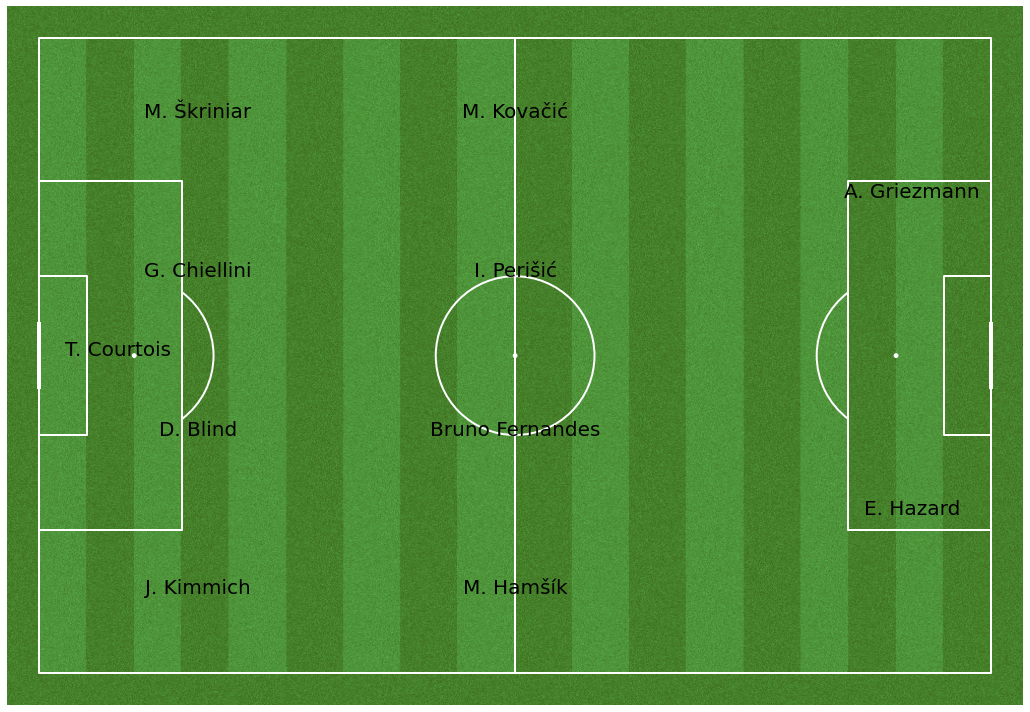

In [ ]:
from mplsoccer.pitch import Pitch
pitch = Pitch(pitch_color='grass', line_color='white', stripe=True)
fig, ax = pitch.draw(figsize=(20, 10))
places = [(10,40),(20,10),(20,30),(20,50),(20,70),(60,10),(60,30),(60,50),(60,70),(110,20),(110,60)]
j = 0

for i in the_best_players:
  
  for key,value in i.items():
    if key == "Name: ":
      annotation = ax.annotate(value ,places[j], fontsize=20, ha='center')
  j+=1

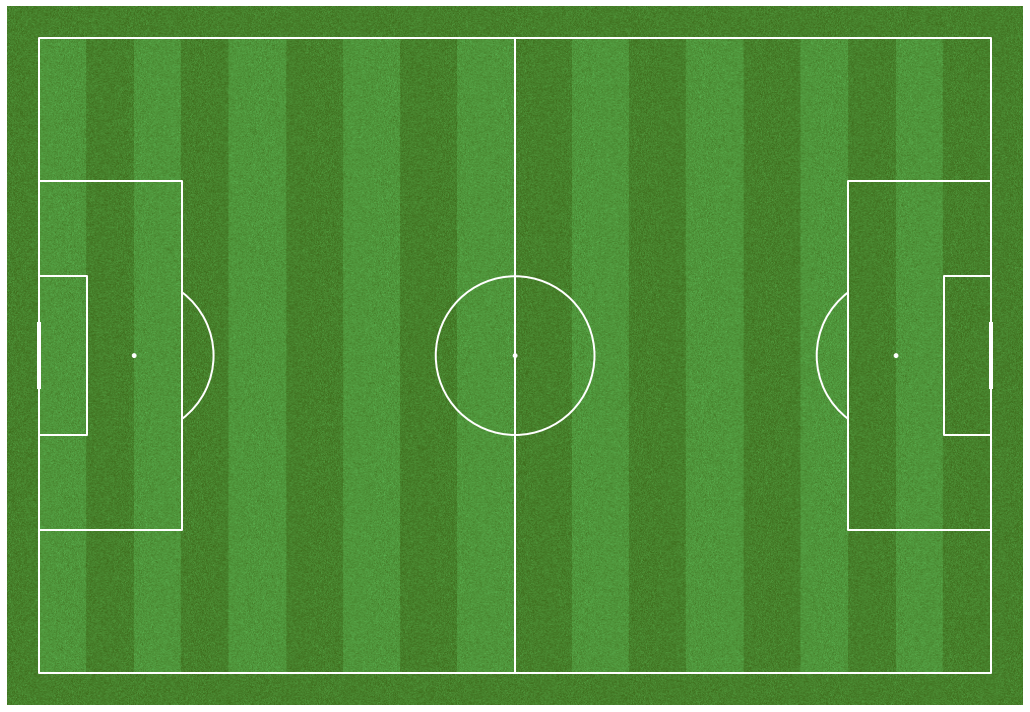

In [ ]:
from mplsoccer.pitch import Pitch
pitch = Pitch(pitch_color='grass', line_color='white', stripe=True)
fig, ax = pitch.draw(figsize=(20, 10))
places = [(10,40),(20,10),(20,30),(20,50),(20,70),(60,10),(60,30),(60,50),(60,70),(110,20),(110,60)]
j = 0

